In [ ]:
!pip install -q pyarrow
!gdown https://drive.google.com/uc?id=1HjAHsB2zpUxA9Do3tBwjPbVQHEGFfEaU
!gdown https://drive.google.com/uc?id=1nrOugQVzM5T0GbBwwd0yf3t4d5ijegDQ
!gdown https://drive.google.com/uc?id=1Gkw602a8NckoZOni6NMFEibzDLA_Q1uE
!pip install -q tsfresh
!pip install -q optuna
!pip install -q shap

Downloading...
From: https://drive.google.com/uc?id=1HjAHsB2zpUxA9Do3tBwjPbVQHEGFfEaU
To: /content/dataset_train_small.parquet
100% 396M/396M [00:04<00:00, 86.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1nrOugQVzM5T0GbBwwd0yf3t4d5ijegDQ
To: /content/target_train_small.parquet
100% 1.96M/1.96M [00:00<00:00, 98.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Gkw602a8NckoZOni6NMFEibzDLA_Q1uE
To: /content/DAIB_data.csv
100% 109M/109M [00:02<00:00, 41.1MB/s]
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.3/95.3 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.2/136.2 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 10.1 MB/s eta 0:00:00


In [ ]:
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('Set3')
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute, roll_time_series
from tsfresh.feature_extraction import settings
import random
import numpy as np

from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score, roc_curve, auc, recall_score, precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

import xgboost as xgb

import matplotlib
import matplotlib.pyplot as plt

import warnings
import plotly.graph_objs as go
warnings.filterwarnings('ignore')
import optuna
import shap

import pandas as pd
import plotly.express as px

In [ ]:



dataset_train_small = pd.read_parquet('dataset_train_small.parquet', engine='auto')
target_train_small = pd.read_parquet("target_train_small.parquet")

# 1. EDA

## Checking for missing values



In [ ]:
print(dataset_train_small.isna().any(), end='\n\n')
print(target_train_small.isna().any())

app_id                  False
amnt                    False
currency                False
operation_kind          False
card_type               False
operation_type          False
operation_type_group    False
ecommerce_flag          False
payment_system          False
income_flag             False
mcc                     False
country                 False
city                    False
mcc_category            False
day_of_week             False
hour                    False
days_before             False
weekofyear              False
hour_diff               False
transaction_number      False
dtype: bool

app_id     False
product    False
flag       False
dtype: bool


**Conclusions:** No missing values in both datasets.

## Data aggregation


In [ ]:
rng = np.random.default_rng(42)

In [ ]:
settings_minimal = settings.MinimalFCParameters()
settings_time = settings.TimeBasedFCParameters()
settings_time.update(settings_minimal)

fc_parameters = {
    "abs_energy": None,
    "count_above_mean": None,
    "count_above": [{'t':0.9}],
    "count_below_mean": None,
    "count_below": [{'t':0.1}],
    'longest_strike_above_mean': None,
    'longest_strike_below_mean': None,
    'mean_abs_change': None,
    'quantile': [{'q': 0.75}, {'q': 0.25}],
}
fc_parameters.update(dict(settings_time))

In [ ]:
app_ids = rng.choice(dataset_train_small.app_id.unique(), size=150000)

Cells below executes in ~ 10 minutes. They generate time series features and take much time since we have more than 1 million observations. Not to waste your time, we have saved the computed dataframe on google drive and one can simly download it directly.

In [ ]:
#features = extract_features(dataset_train_small.loc[dataset_train_small.app_id.isin(app_ids), ['app_id', 'amnt', 'days_before', 'hour_diff', 'transaction_number']], column_id="app_id", column_sort="transaction_number", default_fc_parameters=fc_parameters, disable_progressbar=False)



In [ ]:
#data = features.reset_index().rename(columns={'index':'app_id'})

In [ ]:
# agg_transactions = dataset_train_small[dataset_train_small.app_id.isin(app_ids)].groupby('app_id').agg({
#     'currency': ['nunique', 'mean'],
#     'operation_kind': ['nunique', 'mean'],
#     'card_type': ['nunique', 'mean'],
#     'operation_type': ['nunique', 'mean'],
#     'operation_type_group': ['nunique', 'mean'],
#     'ecommerce_flag': ['nunique', 'mean'],
#     'payment_system': ['nunique', 'mean'],
#     'income_flag': ['nunique', 'mean'],
#     'mcc': ['nunique', 'mean'],
#     'country': ['nunique', 'mean'],
#     'city': ['nunique', 'mean'],
#     'mcc_category': ['nunique', 'mean'],
#     'day_of_week': ['nunique', 'mean'],
#     'hour': ['nunique', 'mean'],
#     'weekofyear': ['max', 'mean'],
# })

In [ ]:
# agg_transactions.columns = agg_transactions.columns.map('_'.join)
# agg_transactions = agg_transactions.reset_index()

In [ ]:
# data = data.merge(agg_transactions, on='app_id', how='left').merge(target_train_small, on='app_id', how='left')

In [ ]:
# data = data.fillna(data.mean())

In [ ]:
data = pd.read_csv('DAIB_data.csv').drop(columns='Unnamed: 0')

## Statistical analysis

In [ ]:
display(data.describe())
print('Num of observations:', data.shape[0])
print('Num of features:', data.shape[1])

,app_id,amnt__abs_energy,amnt__count_above_mean,amnt__count_above__t_0.9,amnt__count_below_mean,amnt__count_below__t_0.1,amnt__longest_strike_above_mean,amnt__longest_strike_below_mean,amnt__mean_abs_change,amnt__quantile__q_0.75,...,mcc_category_nunique,mcc_category_mean,day_of_week_nunique,day_of_week_mean,hour_nunique,hour_mean,weekofyear_max,weekofyear_mean,product,flag
count,123493.000000,123493.000000,123493.000000,1.234930e+05,123493.000000,123493.000000,123493.000000,123493.000000,123493.000000,123493.000000,...,123493.000000,123493.000000,123493.000000,123493.000000,123493.000000,123493.000000,123493.000000,123493.000000,123493.000000,123493.000000
mean,404923.582770,11.906754,39.704809,4.284458e-08,47.001166,0.005432,5.526046,6.511738,0.082395,0.432127,...,8.734098,4.095220,6.219267,3.863009,13.000097,13.852079,44.373430,25.211803,0.863231,0.026131
std,232518.407396,13.092384,43.375506,1.505626e-05,51.632855,0.024649,3.262178,3.934445,0.031409,0.069497,...,4.935403,1.718831,1.467488,0.572894,5.672449,2.269891,8.059416,9.391157,1.145809,0.159526
min,14.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,203674.000000,3.264734,9.000000,0.000000e+00,10.000000,0.000000,3.000000,4.000000,0.067875,0.383153,...,5.000000,2.884615,6.000000,3.604651,9.000000,12.600000,43.000000,16.747153,0.000000,0.000000
50%,406927.000000,8.005593,26.000000,0.000000e+00,31.000000,0.000000,5.000000,6.000000,0.080407,0.423416,...,9.000000,3.904255,7.000000,3.870690,14.000000,14.200000,44.000000,25.063492,0.000000,0.000000
75%,606730.000000,16.060725,56.000000,0.000000e+00,67.000000,0.000000,7.000000,9.000000,0.094465,0.477944,...,12.000000,4.974522,7.000000,4.117647,17.000000,15.372881,50.000000,33.396739,1.000000,0.000000
max,805132.000000,542.603371,2361.000000,5.291005e-03,1099.000000,1.000000,112.000000,120.000000,0.687668,0.745840,...,26.000000,27.000000,7.000000,7.000000,24.000000,23.000000,52.000000,52.000000,4.000000,1.000000


Num of observations: 123493
Num of features: 93


## Correlation heatmap

As we have many features, for the ease of illustration let's display only 10 most correlated with target

In [ ]:
corr_atrr = (data
  .corr()['flag']
  .apply(lambda x: abs(x))
  .sort_values().dropna()[-10:].keys())

In [ ]:
fig = px.imshow(data.corr().loc[corr_atrr, corr_atrr], text_auto=True, width=800, height=800)
fig.show()

**Conclusions:** No highly correlated with target features. `amnt_mean`, `amnt_median` are the most correalted with target $≈5\%$. Moreover, slight multicollinearity persists.

In [ ]:
# for col in data.columns:
#     plt.figure()
#     sns.boxplot(x=col, data=data)
#     plt.title(col)

Columns contain multiple outliers. Let's remove the ones whose all attributes are not in the inter whisker range.

In [ ]:
# print('Old num of observations:', data.shape[0])
# # Removing outliers
# data=data.query(
#     '''0.55>amnt_mean > 0.2 & \
#     0.55>amnt_median >0.2 & \
#     0.4<amnt_max<0.75 & \
#     amnt_min<0.4 & \
#     card_type_nunique<3 & \
#     operation_type_nunique <10.0 & \
#     mcc_nunique <40 & \
#     country_nunique <3 & \
#     city_nunique<10 & \
#     hour_nunique>5 & \
#     mcc_category_nunique<22 & \
#     day_of_week_nunique >5 & \
#     days_before_max>82 & \
#     weekofyear_max>35 & \
#     hour_diff_mean <120 & \
#     hour_diff_max <800 & \
#     hour_diff_min<1000 & \
#     transaction_number_max<230 & \
#     product<3'''
# )
# print('New num of observations:', data.shape[0])

**Conclusion:**
- Outliers are removed by dropping 200000 observations.

## Distribution of the target varibale by products

In [ ]:
target_distribution = (data
              .loc[:, ['product', 'flag']]
              .assign(cnt=1)
              .groupby(by=['product','flag'], as_index=False).count())

fig = px.bar(target_distribution, x="product", y="cnt", color="flag", title="Target distribution")
fig.show()

display(target_distribution
 .merge(data[['product']]
        .assign(total=1)
        .groupby(by='product', as_index=False).sum(), on='product')
 .assign(percent=lambda x: x['cnt'] / x['total'])
 .drop(columns=['cnt', 'total']))

,product,flag,percent
0,0,0,0.977721
1,0,1,0.022279
2,1,0,0.977178
3,1,1,0.022822
4,2,0,0.935906
5,2,1,0.064094
6,3,0,0.979337
7,3,1,0.020663
8,4,0,0.972982
9,4,1,0.027018


What immediately catches the eye is the imbalance of the data. For products 0,1, 3, 4 the number of defaults is approximately $2\%$, while for the 2-nd product the rate of default is 3 times higher equialling $6\%$. Moreover, the most purchased product is 0.

**Conclusions:** data is imbalanced. People default more frequently on the 2-nd product. Applications for the purchase of 0 product are the most frequent in the dataset.

## Dropping duplicates

In [ ]:
data = data.drop_duplicates()

**Conclusion:** No duplicates in data. This proves that data is well-organized.

## Business conclusion
Even though the dataset is large and it contains a great variety of transactions, our analysis showed that the correlation between the features and target variable is small. So here we can not say that there is any linear relationship and maybe our set of features is not that helpful in predicting default as we expected. So we suppose that the company should try to use other features in order to get more precise predictions and collect other data as it seems that transaction's history sligthly affect the possibility of default. However, we can not say for sure that there are not any relationship between the features and the target variable as we explored the data only for the linear type of relationships, which usually contributes to the overall accuracy of the predictions (but obviously the relationships can be quadratic, logorithmic, exponential, ....)

# 2. Imbalanced data problem.

In [ ]:
data.flag.value_counts() / data.flag.value_counts().sum()

0    0.973869
1    0.026131
Name: flag, dtype: float64

As been shown above, the target variable is highly imbalanced. Only $2\%$ of the observations correspond to the default case. Clearly, models built on current data will be unprecise and spurious, since predicting $0$ for all cases will produce $97\%$ accuracy. There are 2 well-known steps of dealing with imbalanced data. First of all, transform the data to mitigate the effect of class imbalance. Secondly, use imbalance robust metrics, such as `f1` and `roc_auc`. In this section, we will discuss the first step. We are to present and use 3 approaches: Undersampling, SMOT (Synthetic minority oversampling technique) and weighting. By undersampling we will randomly drop $10\%$ of class 0 observations, making class imbalance $10\%$ on $90\%$. After than, we will oversample minority class to obtain $30\%$ on $70\%$. Finally, each observation of the 1-class will be assigned with the weight = count(negative class)/count(positive class)

In [ ]:
# Undersampling
data_class_0 = data[data['flag'] == 0]
data_class_1 = data[data['flag'] == 1]
# Reduce a larger class by deleting existing examples
data_class_0_undersampled = resample(data_class_0,
                                    replace=False,
                                    n_samples=round(0.3*len(data_class_0)),
                                    random_state=42)
data_undersampled = pd.concat([data_class_0_undersampled, data_class_1])
print(data_undersampled.flag.value_counts() / data_undersampled.flag.value_counts().sum())

0    0.917903
1    0.082097
Name: flag, dtype: float64


In [ ]:
# Oversampling (SMOTE)
X = data_undersampled.drop('flag', axis=1)
y = data_undersampled['flag']

sm = SMOTE(sampling_strategy = 0.4, random_state=42)

X_new, y_new = sm.fit_resample(X, y)
print(y_new.value_counts() / y_new.value_counts().sum())
data_SMOTE = X_new.join(y_new)

0    0.714286
1    0.285714
Name: flag, dtype: float64


In [ ]:
# Weighting
weights = data_SMOTE.query('flag == 0').shape[0] / data_SMOTE.query('flag == 1').shape[0]
print(weights)

2.5


In [ ]:
data_modified = data_SMOTE

Now, after all transformation performed, let's compare the Random forest model on raw and transformed data to assess the valuability of transformations.

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
X_raw, y_raw = data.drop(columns='flag'), data['flag']
X_modif, y_modif = data_modified.drop(columns='flag'), data_modified['flag']

scores_raw = cross_val_score(model, X, y, cv=3, scoring='f1', error_score='raise')
print(f"Mean f1 raw data: {scores_raw.mean():.3f} (+/- {scores_raw.std() * 2:.3f})")
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight={0:1, 1:weights})
scores_modified = cross_val_score(model, X_modif, y_modif, cv=3, scoring='f1', error_score='raise')
print(f"Mean f1 modified data: {scores_modified.mean():.3f} (+/- {scores_modified.std() * 2:.3f})")


KeyboardInterrupt: ignored

**Conclusions**. Clearly, our transformations were succesfull and viable. Model built on raw data obtains zero metric scores, because positive class observations simply do not fall into the testing buckets. Scores on modified data are non-zero and close to 1.

## Business meaning
As a business problem imbalanced data mean relatively low observation rate of defalut. It is highly important to recognize what are the expected results when dealing with imbalanced data. Due to the fact that default is an extremely unpleasant situation, sometimes it makes sense to better miscalssfy some observations (increase False Positive classifications) to be default if it increases the proporation of those that classified correctly to be a default (increase True Positive classifications). Similar, situation often appears in medical test when it is better to recognize a healthy person as an ill one rather than the ill one to be healthy. However, it is important to know what is the loss from misscalssfing a default observation and miscalssifying a non-default one. It could be proposed to target the some proportion FalseNegative/FalsePositive = lambda, where lambda may equal to ratio of estimations of expected values of losses from misscalssfing default observation and miscalssifying non-default one.

# 3. Model creation (make more than 5 models).

### Auxillary functions

In [ ]:
from numpy import sqrt
from numpy import argmax

def plot_roc_curve(title, fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""

    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(12, 8))

    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr,
                tpr,
                lw=1,
                alpha=0.3,
                label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc)
        )

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Constant Random Model', alpha=.8)

    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    ax.plot(
        mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8
    )

    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

    ax.fill_between(
        mean_fpr, tprs_lower, tprs_upper,
        color='grey', alpha=.2,
        label=r'$\pm$ 1 std. dev.'
    )

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for {title} model')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)


# def compute_roc_auc(clf, section):
#     y_predict = clf.predict_proba(section[features])[:, 1]
#     fpr, tpr, thresholds = roc_curve(section.flag.values, y_predict)
#     auc_score = auc(fpr, tpr)
#     return fpr, tpr, auc_score

def compute_scores(clf, section):
    y_predict = clf.predict_proba(section[features])[:, 1]
    fpr, tpr, thresholds = roc_curve(section.flag.values, y_predict)
    gmeans = sqrt(tpr**2 + (1-fpr)**2)
    ix = argmax(gmeans)
    best_thresh = thresholds[ix]
    auc_score = auc(fpr, tpr)
    precision_s = precision_score(section.flag.values, np.where(y_predict < best_thresh, 0, 1))
    recall_s = recall_score(section.flag.values, np.where(y_predict < best_thresh, 0, 1))
    f1 = f1_score(section.flag.values, np.where(y_predict < best_thresh, 0, 1))
    return fpr, tpr, auc_score, precision_s, recall_s, f1, best_thresh



## First of all, we start with basic models: logistic regression, KNN, decision trees, LDA, QDA

In [ ]:
# train / test plit
df = data_modified
data_modified = df.sample(frac=0.85, random_state = 41)
data_modified_rest = df.loc[~df.index.isin(data_modified.index)]

### Logistic regression

Training with fold 1 started.
Val ROC-AUC: 0.7861180059980775
Training with fold 1 completed.
Training with fold 2 started.
Val ROC-AUC: 0.7780626896195888
Training with fold 2 completed.
Training with fold 3 started.
Val ROC-AUC: 0.7972552343679304
Training with fold 3 completed.
Training with fold 4 started.
Val ROC-AUC: 0.783540216652512
Training with fold 4 completed.
Training with fold 5 started.
Val ROC-AUC: 0.7828600527088664
Training with fold 5 completed.


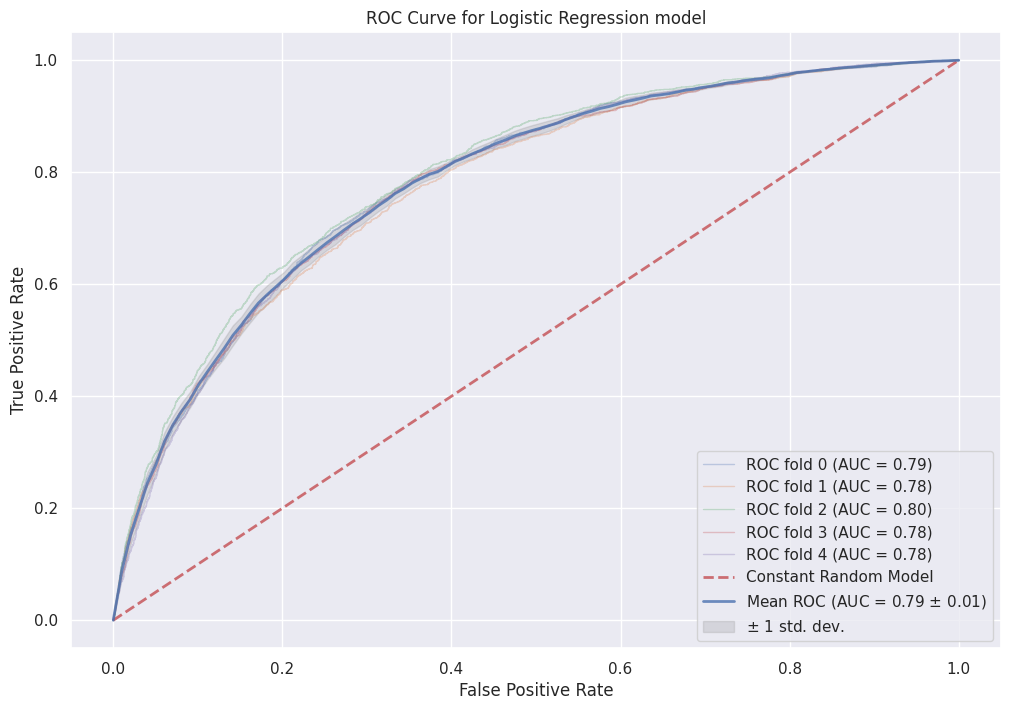

,AUC Train,AUC Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test,Thresh Train,Thresh Test
0,0.788172,0.786118,0.459649,0.432185,0.804922,0.857143,0.585150,0.574632,0.432534,0.381257
1,0.789839,0.778063,0.432875,0.445261,0.856648,0.810320,0.575129,0.574720,0.382838,0.417956
2,0.785799,0.797255,0.457216,0.421540,0.810656,0.892021,0.584672,0.572524,0.430062,0.353355
3,0.789189,0.783540,0.443571,0.467638,0.835742,0.797420,0.579547,0.589544,0.404077,0.448100
4,0.789002,0.782860,0.462395,0.474140,0.803392,0.784417,0.586962,0.591032,0.433580,0.455897


In [ ]:
targets = data_modified.flag.values
features = [x for x in data_modified.columns if x not in ['app_id', 'flag']]

cv = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)
fprs, tprs, scores = [], [], []

logreg_clf = make_pipeline(StandardScaler(), LogisticRegression(
    random_state=41,
    C=0.1,
    penalty='l2',
    class_weight={0:1, 1:weights}
))

for fold_, (train_idx, val_idx) in enumerate(cv.split(data_modified, targets), 1):
    print(f'Training with fold {fold_} started.')

    train, val = data_modified.iloc[train_idx], data_modified.iloc[val_idx]

    logreg_clf.fit(train[features], train.flag.values)
    _, _, auc_score_train, precision_tr, recall_tr, f1_tr, thresh_tr = compute_scores(logreg_clf, train)
    fpr, tpr, auc_score, precision, recall, f1, thresh = compute_scores(logreg_clf, val)
    print('Val ROC-AUC:', auc_score)
    scores.append((auc_score_train, auc_score,
                   precision_tr, precision,
                   recall_tr, recall,
                   f1_tr, f1,
                   thresh_tr, thresh))
    fprs.append(fpr)
    tprs.append(tpr)
    print(f'Training with fold {fold_} completed.')

plot_roc_curve('Logistic Regression', fprs, tprs)
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test',
                              'Precision Train', 'Precision Test',
                              'Recall Train', 'Recall Test',
                              'F1 Train', 'F1 Test',
                              'Thresh Train', 'Thresh Test'])

### KNN

Training with fold 1 started.
Val ROC-AUC: 0.8666803014420312
Training with fold 1 completed.
Training with fold 2 started.
Val ROC-AUC: 0.864369257494247
Training with fold 2 completed.
Training with fold 3 started.
Val ROC-AUC: 0.8654096700873832
Training with fold 3 completed.
Training with fold 4 started.
Val ROC-AUC: 0.8700414402948269
Training with fold 4 completed.
Training with fold 5 started.
Val ROC-AUC: 0.8608947599954614
Training with fold 5 completed.


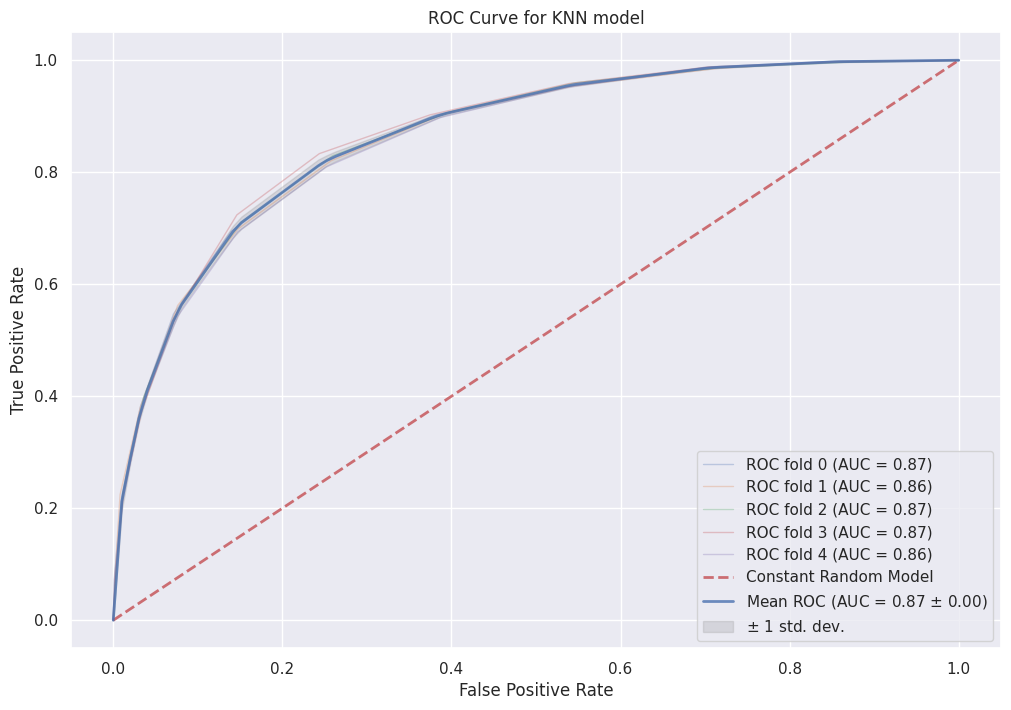

,AUC Train,AUC Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test,Thresh Train,Thresh Test
0,0.923263,0.866680,0.637122,0.571429,0.885318,0.816054,0.740989,0.672176,0.5,0.5
1,0.922600,0.864369,0.636090,0.561662,0.884721,0.820354,0.740082,0.666796,0.5,0.5
2,0.923426,0.865410,0.640225,0.562358,0.882212,0.829431,0.741987,0.670270,0.5,0.5
3,0.922269,0.870041,0.636387,0.578825,0.882929,0.833254,0.739655,0.683118,0.5,0.5
4,0.923019,0.860895,0.637232,0.563770,0.884376,0.809273,0.740733,0.664573,0.5,0.5


In [ ]:
targets = data_modified.flag.values
features = [x for x in data_modified.columns if x not in ['app_id', 'flag']]

cv = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)
fprs, tprs, scores = [], [], []

knn_clf = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors = 10))

for fold_, (train_idx, val_idx) in enumerate(cv.split(data_modified, targets), 1):
    print(f'Training with fold {fold_} started.')

    train, val = data_modified.iloc[train_idx], data_modified.iloc[val_idx]

    knn_clf.fit(train[features], train.flag.values)
    _, _, auc_score_train, precision_tr, recall_tr, f1_tr, thresh_tr = compute_scores(knn_clf, train)
    fpr, tpr, auc_score, precision, recall, f1, thresh = compute_scores(knn_clf, val)
    print('Val ROC-AUC:', auc_score)
    scores.append((auc_score_train, auc_score,
                   precision_tr, precision,
                   recall_tr, recall,
                   f1_tr, f1,
                   thresh_tr, thresh))
    fprs.append(fpr)
    tprs.append(tpr)
    print(f'Training with fold {fold_} completed.')

plot_roc_curve('KNN', fprs, tprs)
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test',
                              'Precision Train', 'Precision Test',
                              'Recall Train', 'Recall Test',
                              'F1 Train', 'F1 Test',
                              'Thresh Train', 'Thresh Test'])

### Decision trees

Training with fold 1 started.
Val ROC-AUC: 0.8163750011701372
Training with fold 1 completed.
Training with fold 2 started.
Val ROC-AUC: 0.8114786422884103
Training with fold 2 completed.
Training with fold 3 started.
Val ROC-AUC: 0.809836182625105
Training with fold 3 completed.
Training with fold 4 started.
Val ROC-AUC: 0.8136414229676185
Training with fold 4 completed.
Training with fold 5 started.
Val ROC-AUC: 0.8185396570508666
Training with fold 5 completed.


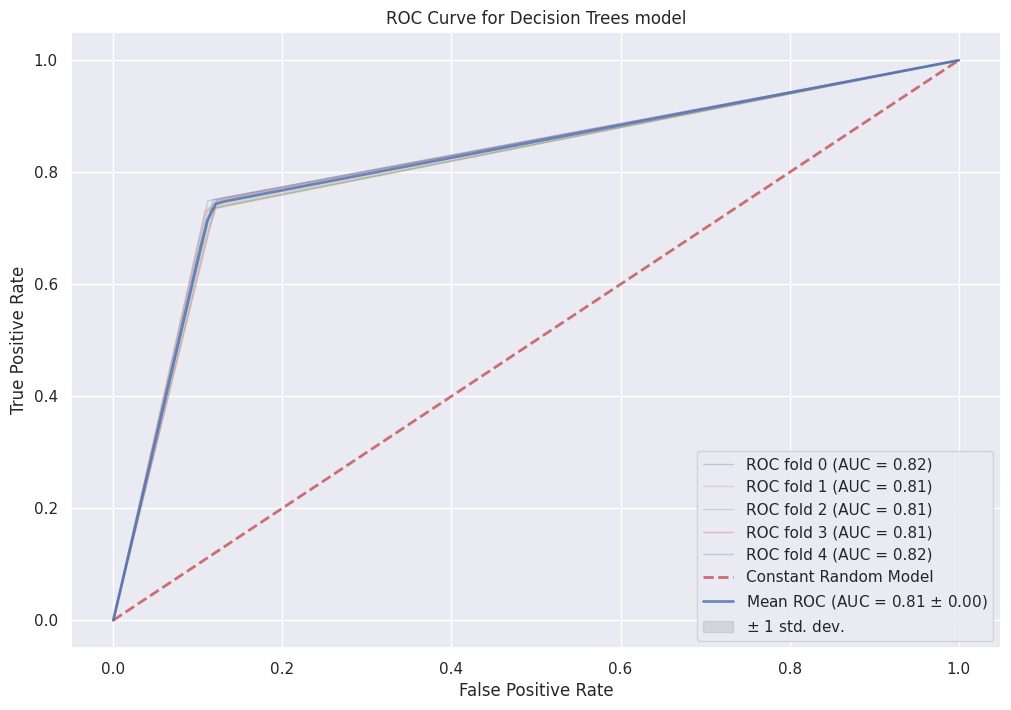

,AUC Train,AUC Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test,Thresh Train,Thresh Test
0,1.0,0.816375,1.0,0.718464,1.0,0.751075,1.0,0.734408,1.0,1.0
1,1.0,0.811479,1.0,0.730439,1.0,0.731486,1.0,0.730962,1.0,1.0
2,1.0,0.809836,1.0,0.718823,1.0,0.735308,1.0,0.726972,1.0,1.0
3,1.0,0.813641,1.0,0.711242,1.0,0.749642,1.0,0.729937,1.0,1.0
4,1.0,0.818540,1.0,0.728837,1.0,0.749044,1.0,0.738802,1.0,1.0


In [ ]:
targets = data_modified.flag.values
features = [x for x in data_modified.columns if x not in ['app_id', 'flag']]

cv = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)
fprs, tprs, scores = [], [], []

dt_clf = make_pipeline(StandardScaler(), DecisionTreeClassifier(class_weight={0:1, 1:weights}))

for fold_, (train_idx, val_idx) in enumerate(cv.split(data_modified, targets), 1):
    print(f'Training with fold {fold_} started.')

    train, val = data_modified.iloc[train_idx], data_modified.iloc[val_idx]

    dt_clf.fit(train[features], train.flag.values)
    _, _, auc_score_train, precision_tr, recall_tr, f1_tr, thresh_tr = compute_scores(dt_clf, train)
    fpr, tpr, auc_score, precision, recall, f1, thresh = compute_scores(dt_clf, val)
    print('Val ROC-AUC:', auc_score)
    scores.append((auc_score_train, auc_score,
                   precision_tr, precision,
                   recall_tr, recall,
                   f1_tr, f1,
                   thresh_tr, thresh))
    fprs.append(fpr)
    tprs.append(tpr)
    print(f'Training with fold {fold_} completed.')

plot_roc_curve('Decision Trees', fprs, tprs)
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test',
                              'Precision Train', 'Precision Test',
                              'Recall Train', 'Recall Test',
                              'F1 Train', 'F1 Test',
                              'Thresh Train', 'Thresh Test'])

### LDA

Training with fold 1 started.
Val ROC-AUC: 0.7841325355230715
Training with fold 1 completed.
Training with fold 2 started.
Val ROC-AUC: 0.7738877318041827
Training with fold 2 completed.
Training with fold 3 started.
Val ROC-AUC: 0.7948301594011394
Training with fold 3 completed.
Training with fold 4 started.
Val ROC-AUC: 0.7833980564525589
Training with fold 4 completed.
Training with fold 5 started.
Val ROC-AUC: 0.7789830831492097
Training with fold 5 completed.


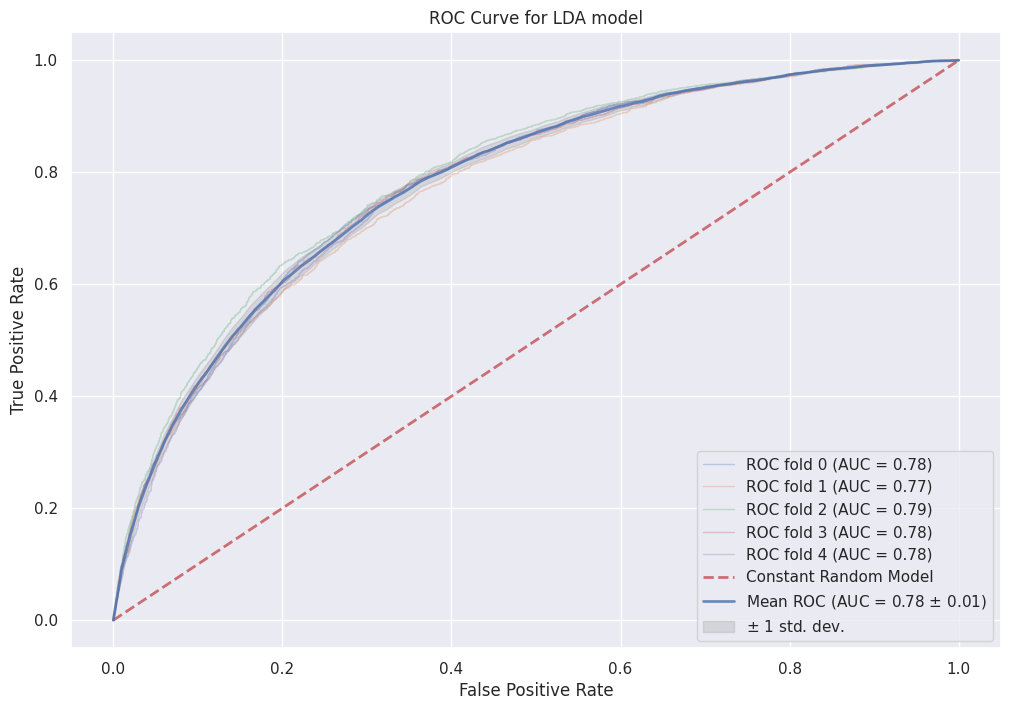

,AUC Train,AUC Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test,Thresh Train,Thresh Test
0,0.785447,0.784133,0.457264,0.494231,0.800143,0.736742,0.581954,0.591598,0.228372,0.265509
1,0.787409,0.773888,0.473765,0.288332,0.776610,1.000000,0.588512,0.447605,0.246012,0.015823
2,0.783716,0.794830,0.487887,0.563776,0.741011,0.633540,0.588380,0.596625,0.266178,0.336494
3,0.786245,0.783398,0.454386,0.473531,0.805639,0.777831,0.581054,0.588682,0.224899,0.250860
4,0.786692,0.778983,0.456004,0.461882,0.804706,0.790631,0.582131,0.583113,0.225241,0.237376


In [ ]:
targets = data_modified.flag.values
features = [x for x in data_modified.columns if x not in ['app_id', 'flag']]

cv = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)
fprs, tprs, scores = [], [], []

lda_clf = make_pipeline(StandardScaler(), LDA())

for fold_, (train_idx, val_idx) in enumerate(cv.split(data_modified, targets), 1):
    print(f'Training with fold {fold_} started.')

    train, val = data_modified.iloc[train_idx], data_modified.iloc[val_idx]

    lda_clf.fit(train[features], train.flag.values)
    _, _, auc_score_train, precision_tr, recall_tr, f1_tr, thresh_tr = compute_scores(lda_clf, train)
    fpr, tpr, auc_score, precision, recall, f1, thresh = compute_scores(lda_clf, val)
    print('Val ROC-AUC:', auc_score)
    scores.append((auc_score_train, auc_score,
                   precision_tr, precision,
                   recall_tr, recall,
                   f1_tr, f1,
                   thresh_tr, thresh))
    fprs.append(fpr)
    tprs.append(tpr)
    print(f'Training with fold {fold_} completed.')

plot_roc_curve('LDA', fprs, tprs)
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test',
                              'Precision Train', 'Precision Test',
                              'Recall Train', 'Recall Test',
                              'F1 Train', 'F1 Test',
                              'Thresh Train', 'Thresh Test'])

### QDA

Training with fold 1 started.
Val ROC-AUC: 0.612977436634087
Training with fold 1 completed.
Training with fold 2 started.
Val ROC-AUC: 0.6169031781661023
Training with fold 2 completed.
Training with fold 3 started.
Val ROC-AUC: 0.6798855614979151
Training with fold 3 completed.
Training with fold 4 started.
Val ROC-AUC: 0.7120808086666879
Training with fold 4 completed.
Training with fold 5 started.
Val ROC-AUC: 0.6932011382676871
Training with fold 5 completed.


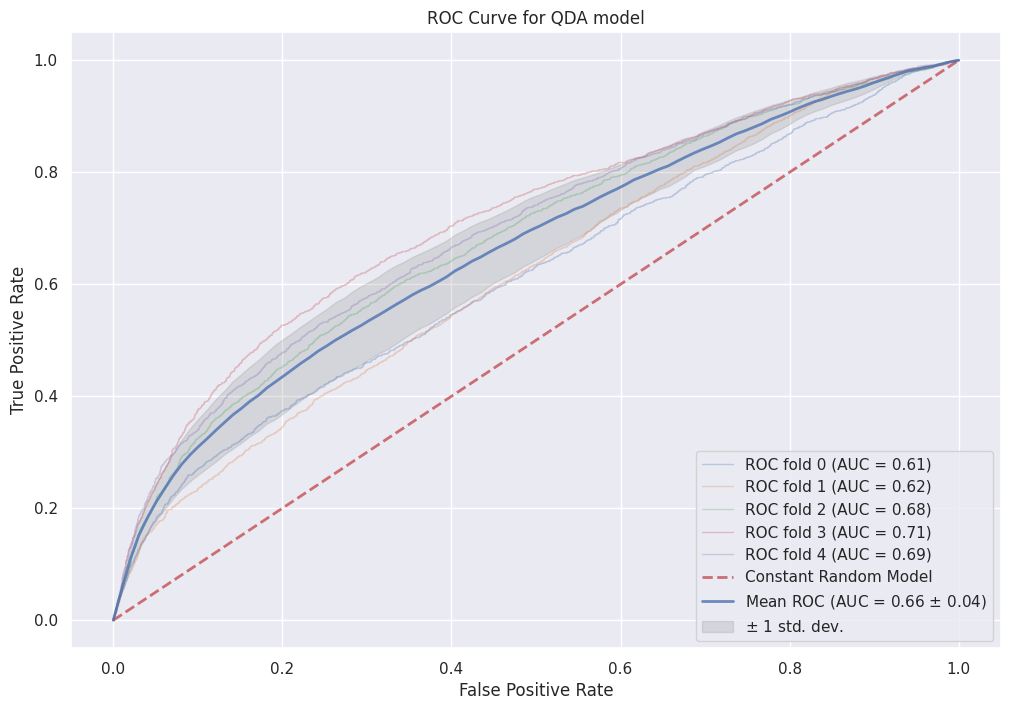

,AUC Train,AUC Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test,Thresh Train,Thresh Test
0,0.621568,0.612977,0.000000,0.000000,0.0,0.0,0.000000,0.000000,2.000000e+00,2.000000e+00
1,0.631519,0.616903,0.000000,0.000000,0.0,0.0,0.000000,0.000000,2.000000e+00,2.000000e+00
2,0.677287,0.679886,0.288049,0.287579,1.0,1.0,0.447264,0.446697,1.155399e-191,1.291458e-211
3,0.728418,0.712081,0.287377,0.287737,1.0,1.0,0.446453,0.446888,6.104438e-165,7.372602e-172
4,0.707781,0.693201,0.287293,0.286890,1.0,1.0,0.446352,0.445865,1.472112e-190,8.812911e-267


In [ ]:
targets = data_modified.flag.values
features = [x for x in data_modified.columns if x not in ['app_id', 'flag']]

cv = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)
fprs, tprs, scores = [], [], []

qda_clf = make_pipeline(StandardScaler(), QDA())

for fold_, (train_idx, val_idx) in enumerate(cv.split(data_modified, targets), 1):
    print(f'Training with fold {fold_} started.')

    train, val = data_modified.iloc[train_idx], data_modified.iloc[val_idx]

    qda_clf.fit(train[features], train.flag.values)
    _, _, auc_score_train, precision_tr, recall_tr, f1_tr, thresh_tr = compute_scores(qda_clf, train)
    fpr, tpr, auc_score, precision, recall, f1, thresh = compute_scores(qda_clf, val)
    print('Val ROC-AUC:', auc_score)
    scores.append((auc_score_train, auc_score,
                   precision_tr, precision,
                   recall_tr, recall,
                   f1_tr, f1,
                   thresh_tr, thresh))
    fprs.append(fpr)
    tprs.append(tpr)
    print(f'Training with fold {fold_} completed.')

plot_roc_curve('QDA', fprs, tprs)
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test',
                              'Precision Train', 'Precision Test',
                              'Recall Train', 'Recall Test',
                              'F1 Train', 'F1 Test',
                              'Thresh Train', 'Thresh Test'])

## Now, let's try more sophisticated models: Random Forests, Gradient Boosting, Neural networks.

### Random Forests

In [ ]:
targets = data_modified.flag.values
features = [x for x in data_modified.columns if x not in ['app_id', 'flag']]

cv = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)
fprs, tprs, scores = [], [], []

rf_clf = make_pipeline(StandardScaler(), RandomForestClassifier(class_weight={0:1, 1:weights}))

for fold_, (train_idx, val_idx) in enumerate(cv.split(data_modified, targets), 1):
    print(f'Training with fold {fold_} started.')

    train, val = data_modified.iloc[train_idx], data_modified.iloc[val_idx]

    rf_clf.fit(train[features], train.flag.values)
    _, _, auc_score_train, precision_tr, recall_tr, f1_tr, thresh_tr = compute_scores(rf_clf, train)
    fpr, tpr, auc_score, precision, recall, f1, thresh = compute_scores(rf_clf, val)
    print('Val ROC-AUC:', auc_score)
    scores.append((auc_score_train, auc_score,
                   precision_tr, precision,
                   recall_tr, recall,
                   f1_tr, f1,
                   thresh_tr, thresh))
    fprs.append(fpr)
    tprs.append(tpr)
    print(f'Training with fold {fold_} completed.')

plot_roc_curve('Random Forest', fprs, tprs)
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test',
                              'Precision Train', 'Precision Test',
                              'Recall Train', 'Recall Test',
                              'F1 Train', 'F1 Test',
                              'Thresh Train', 'Thresh Test'])

Training with fold 1 started.


NameError: ignored

### XGboost

In [ ]:
targets = data_modified.flag.values
features = [x for x in data_modified.columns if x not in ['app_id', 'flag']]

cv = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)
fprs, tprs, scores = [], [], []

xgb_clf = make_pipeline(StandardScaler(), xgb.XGBClassifier(scale_pos_weight=weights, booster="gbtree"))

for fold_, (train_idx, val_idx) in enumerate(cv.split(data_modified, targets), 1):
    print(f'Training with fold {fold_} started.')

    train, val = data_modified.iloc[train_idx], data_modified.iloc[val_idx]

    xgb_clf.fit(train[features], train.flag.values)
    _, _, auc_score_train, precision_tr, recall_tr, f1_tr, thresh_tr = compute_scores(xgb_clf, train)
    fpr, tpr, auc_score, precision, recall, f1, thresh = compute_scores(xgb_clf, val)
    print('Val ROC-AUC:', auc_score)
    scores.append((auc_score_train, auc_score,
                   precision_tr, precision,
                   recall_tr, recall,
                   f1_tr, f1,
                   thresh_tr, thresh))
    fprs.append(fpr)
    tprs.append(tpr)
    print(f'Training with fold {fold_} completed.')

plot_roc_curve('XGboost', fprs, tprs)
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test',
                              'Precision Train', 'Precision Test',
                              'Recall Train', 'Recall Test',
                              'F1 Train', 'F1 Test',
                              'Thresh Train', 'Thresh Test'])

Training with fold 1 started.


NameError: ignored

## Neural networks

Training with fold 1 started.
Val ROC-AUC: 0.8481499625831417
Training with fold 1 completed.
Training with fold 2 started.
Val ROC-AUC: 0.840000392799003
Training with fold 2 completed.
Training with fold 3 started.
Val ROC-AUC: 0.8494657474680525
Training with fold 3 completed.
Training with fold 4 started.
Val ROC-AUC: 0.8445643868233189
Training with fold 4 completed.
Training with fold 5 started.
Val ROC-AUC: 0.8450532284639628
Training with fold 5 completed.


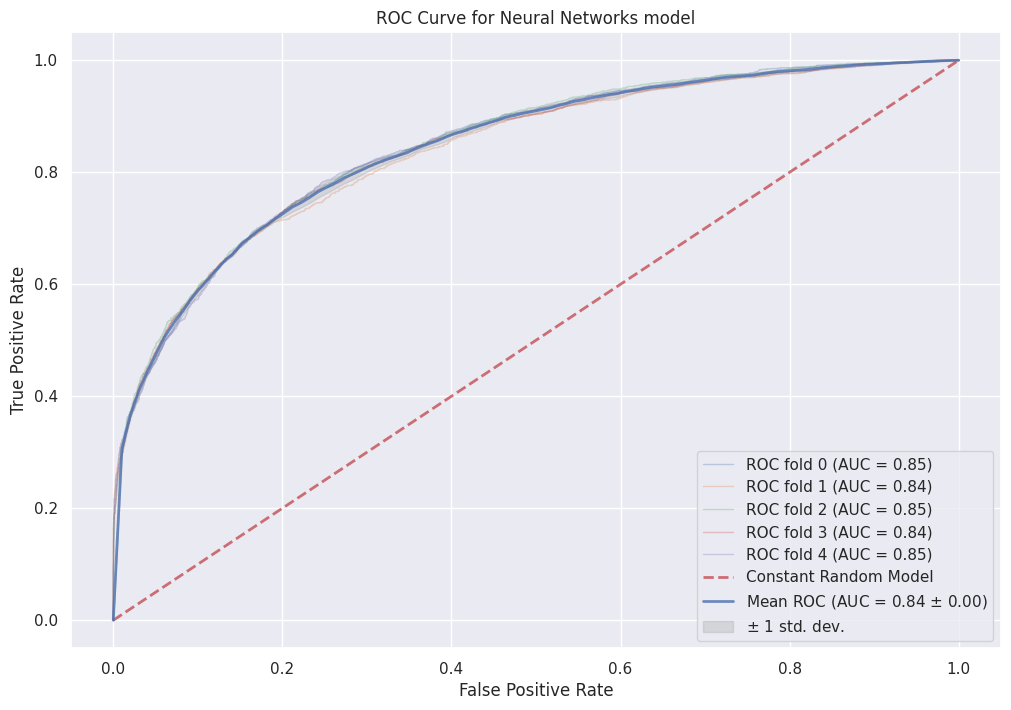

,AUC Train,AUC Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test,Thresh Train,Thresh Test
0,0.857142,0.848150,0.637233,0.581602,0.716402,0.749164,0.674502,0.654834,0.318212,0.275717
1,0.855892,0.840000,0.689972,0.641294,0.654283,0.672241,0.671654,0.656403,0.367628,0.334199
2,0.851037,0.849466,0.644186,0.657907,0.682356,0.657907,0.662722,0.657907,0.315999,0.335770
3,0.859964,0.844564,0.635717,0.585779,0.715685,0.743908,0.673335,0.655441,0.323044,0.281702
4,0.855855,0.845053,0.624437,0.623034,0.728261,0.700765,0.672364,0.659618,0.305555,0.319212


In [ ]:
targets = data_modified.flag.values
features = [x for x in data_modified.columns if x not in ['app_id', 'flag']]

cv = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)
fprs, tprs, scores = [], [], []

nn_clf = make_pipeline(StandardScaler(), MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1))

for fold_, (train_idx, val_idx) in enumerate(cv.split(data_modified, targets), 1):
    print(f'Training with fold {fold_} started.')

    train, val = data_modified.iloc[train_idx], data_modified.iloc[val_idx]

    nn_clf.fit(train[features], train.flag.values)
    _, _, auc_score_train, precision_tr, recall_tr, f1_tr, thresh_tr = compute_scores(nn_clf, train)
    fpr, tpr, auc_score, precision, recall, f1, thresh = compute_scores(nn_clf, val)
    print('Val ROC-AUC:', auc_score)
    scores.append((auc_score_train, auc_score,
                   precision_tr, precision,
                   recall_tr, recall,
                   f1_tr, f1,
                   thresh_tr, thresh))
    fprs.append(fpr)
    tprs.append(tpr)
    print(f'Training with fold {fold_} completed.')

plot_roc_curve('Neural Networks', fprs, tprs)
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test',
                              'Precision Train', 'Precision Test',
                              'Recall Train', 'Recall Test',
                              'F1 Train', 'F1 Test',
                              'Thresh Train', 'Thresh Test'])

## Tuning the parameters

Random Forest algorithm show best cross validated results. Here we will try to further improve the perfomance by searching the optimal hyperparameters.  **Optuna** framework will be used. The goal is to maximize roc-auc.

In [ ]:
targets = data_modified.flag.values
features = [x for x in data_modified.columns if x not in ['app_id', 'flag']]
X_scaled = StandardScaler().fit_transform(data_modified[features])
X_train, X_test, y_train, y_test = train_test_split(X_scaled, targets, test_size=0.9)

Optuna takes quite a long to execute. Therefore, for finding optimal parameters we have only used 10% of the dataset.

In [ ]:
def objective(trial):
    param = {
        "class_weight": {0:1, 1:weights},
        'n_estimators':trial.suggest_int('n_estimators', 100, 1500),
        'max_depth':trial.suggest_int('max_depth', 2, 5),
        'max_features':trial.suggest_float('max_features', 0, 0.3),
        'n_jobs':-1
        }

    rf_clf = RandomForestClassifier()
    rf_clf.set_params(**param)
    mean_metric = cross_val_score(rf_clf, X_scaled, targets,
                              scoring='roc_auc', n_jobs=-1,
                              error_score='raise', cv=3).mean()
    return mean_metric

In [ ]:
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, timeout=1800, n_jobs=-1)

Above code executes in a half an hour. We have executed it and below are the results:

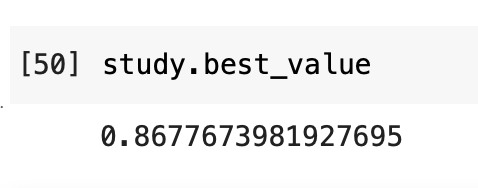

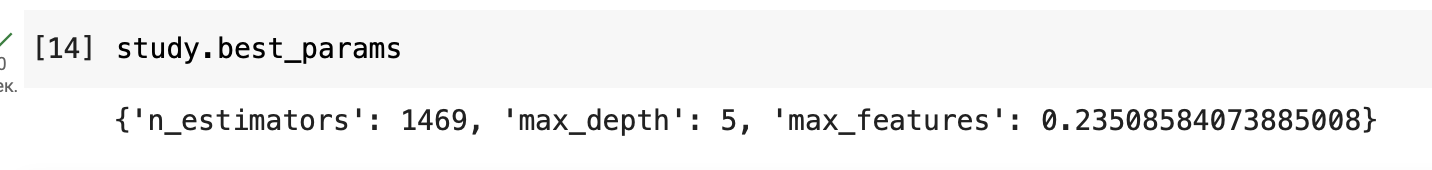

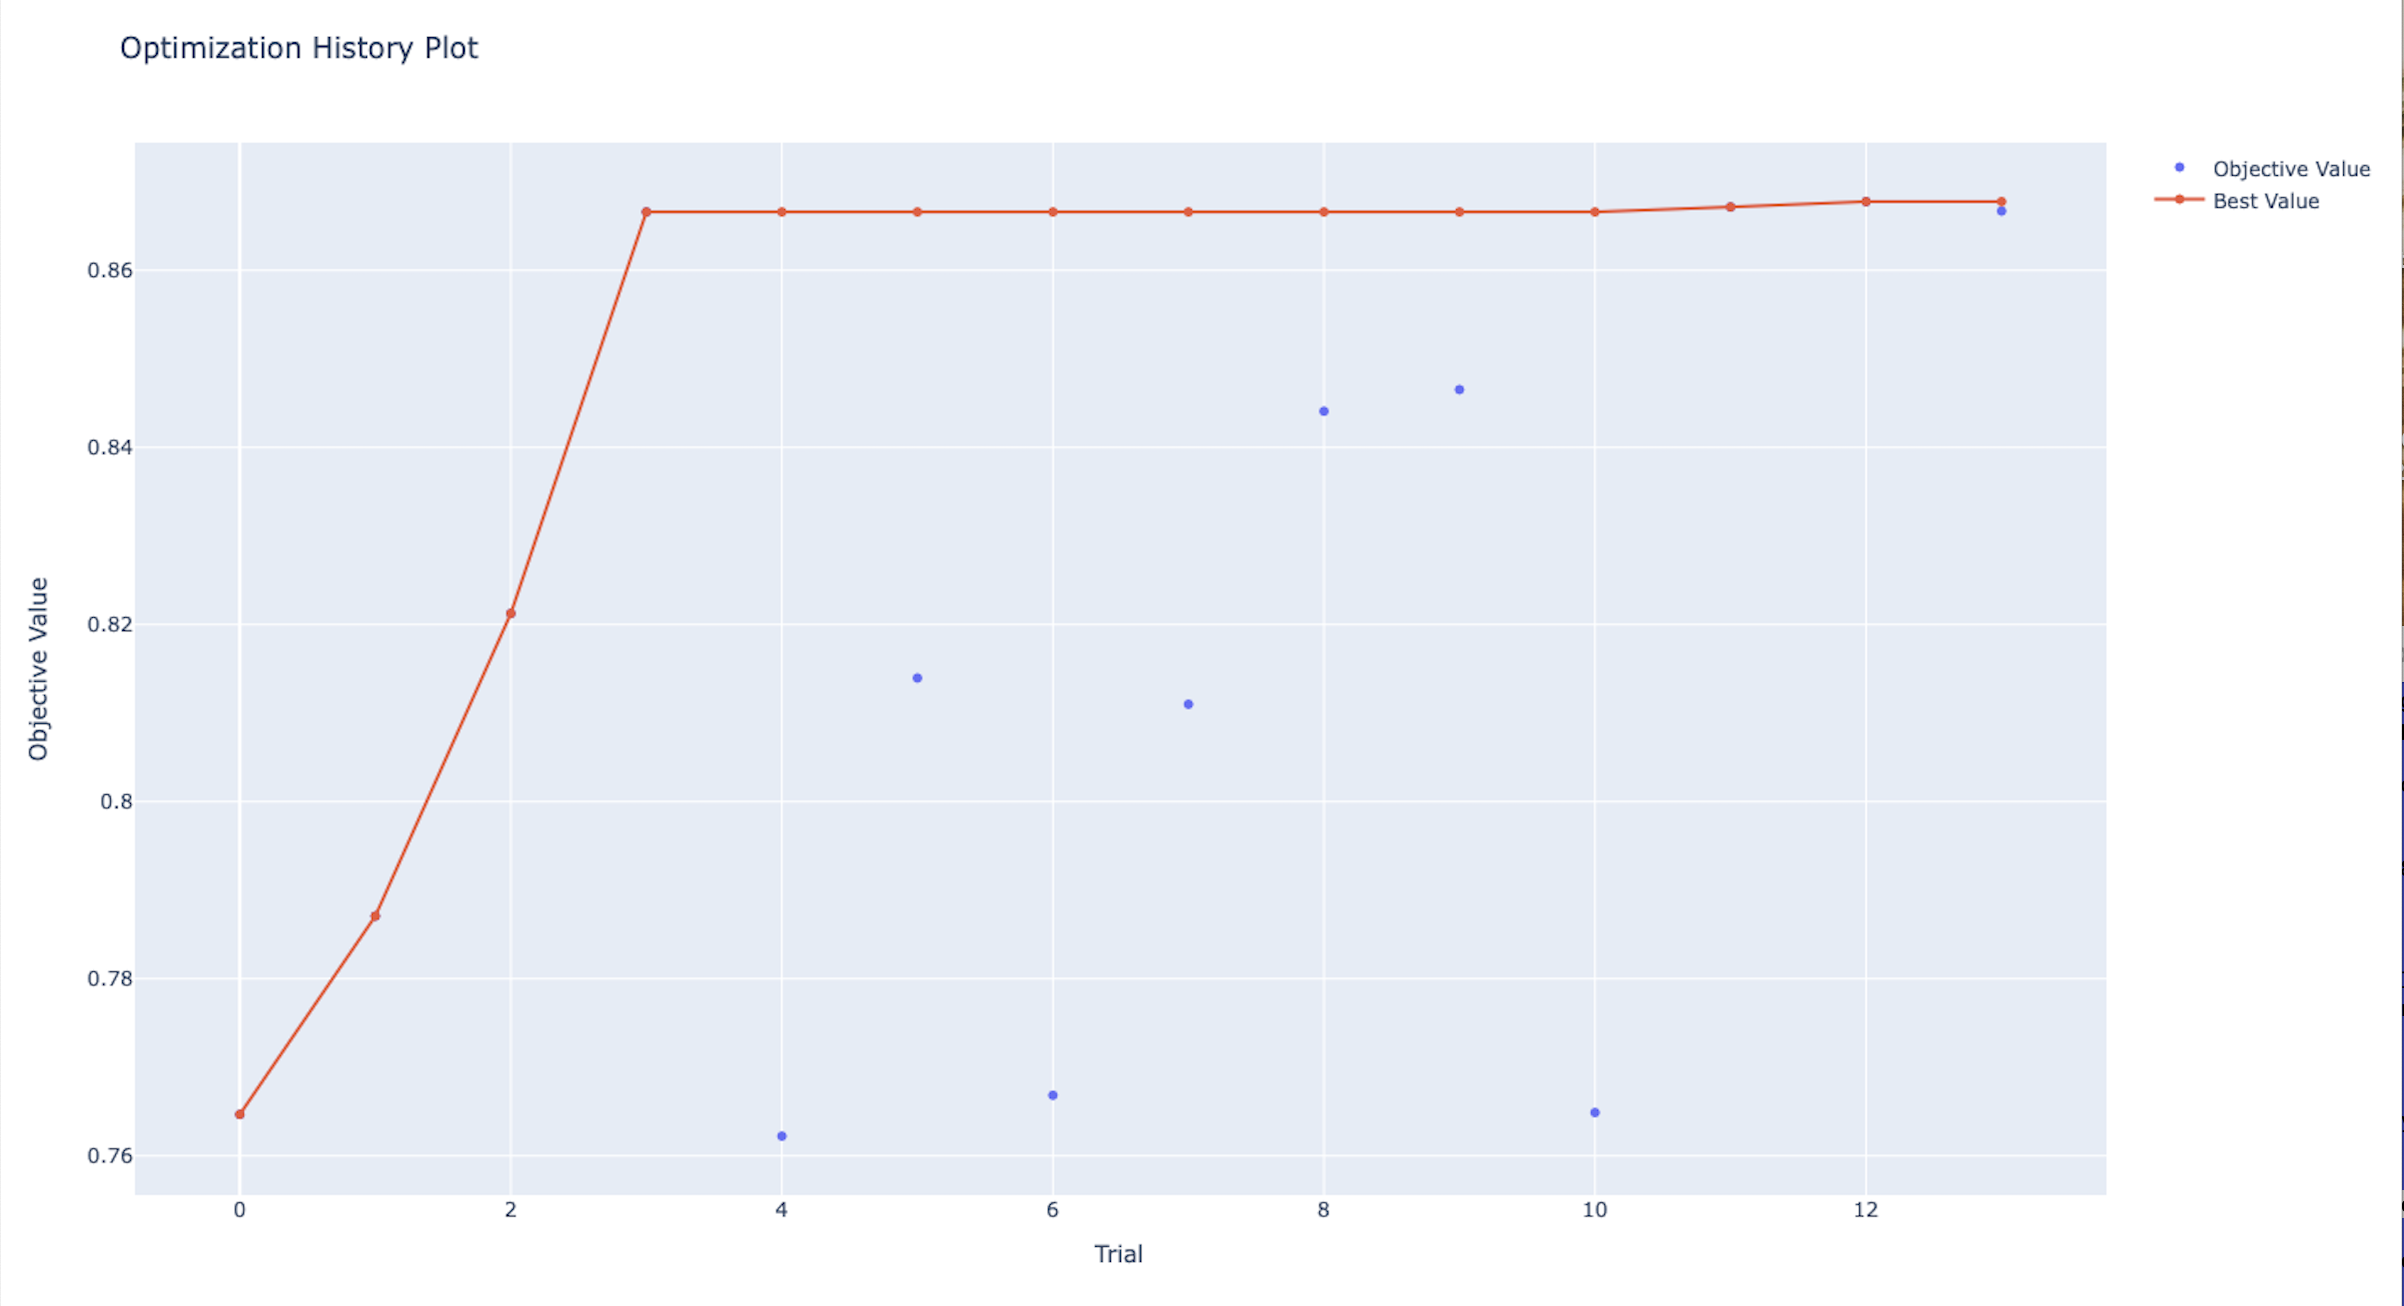

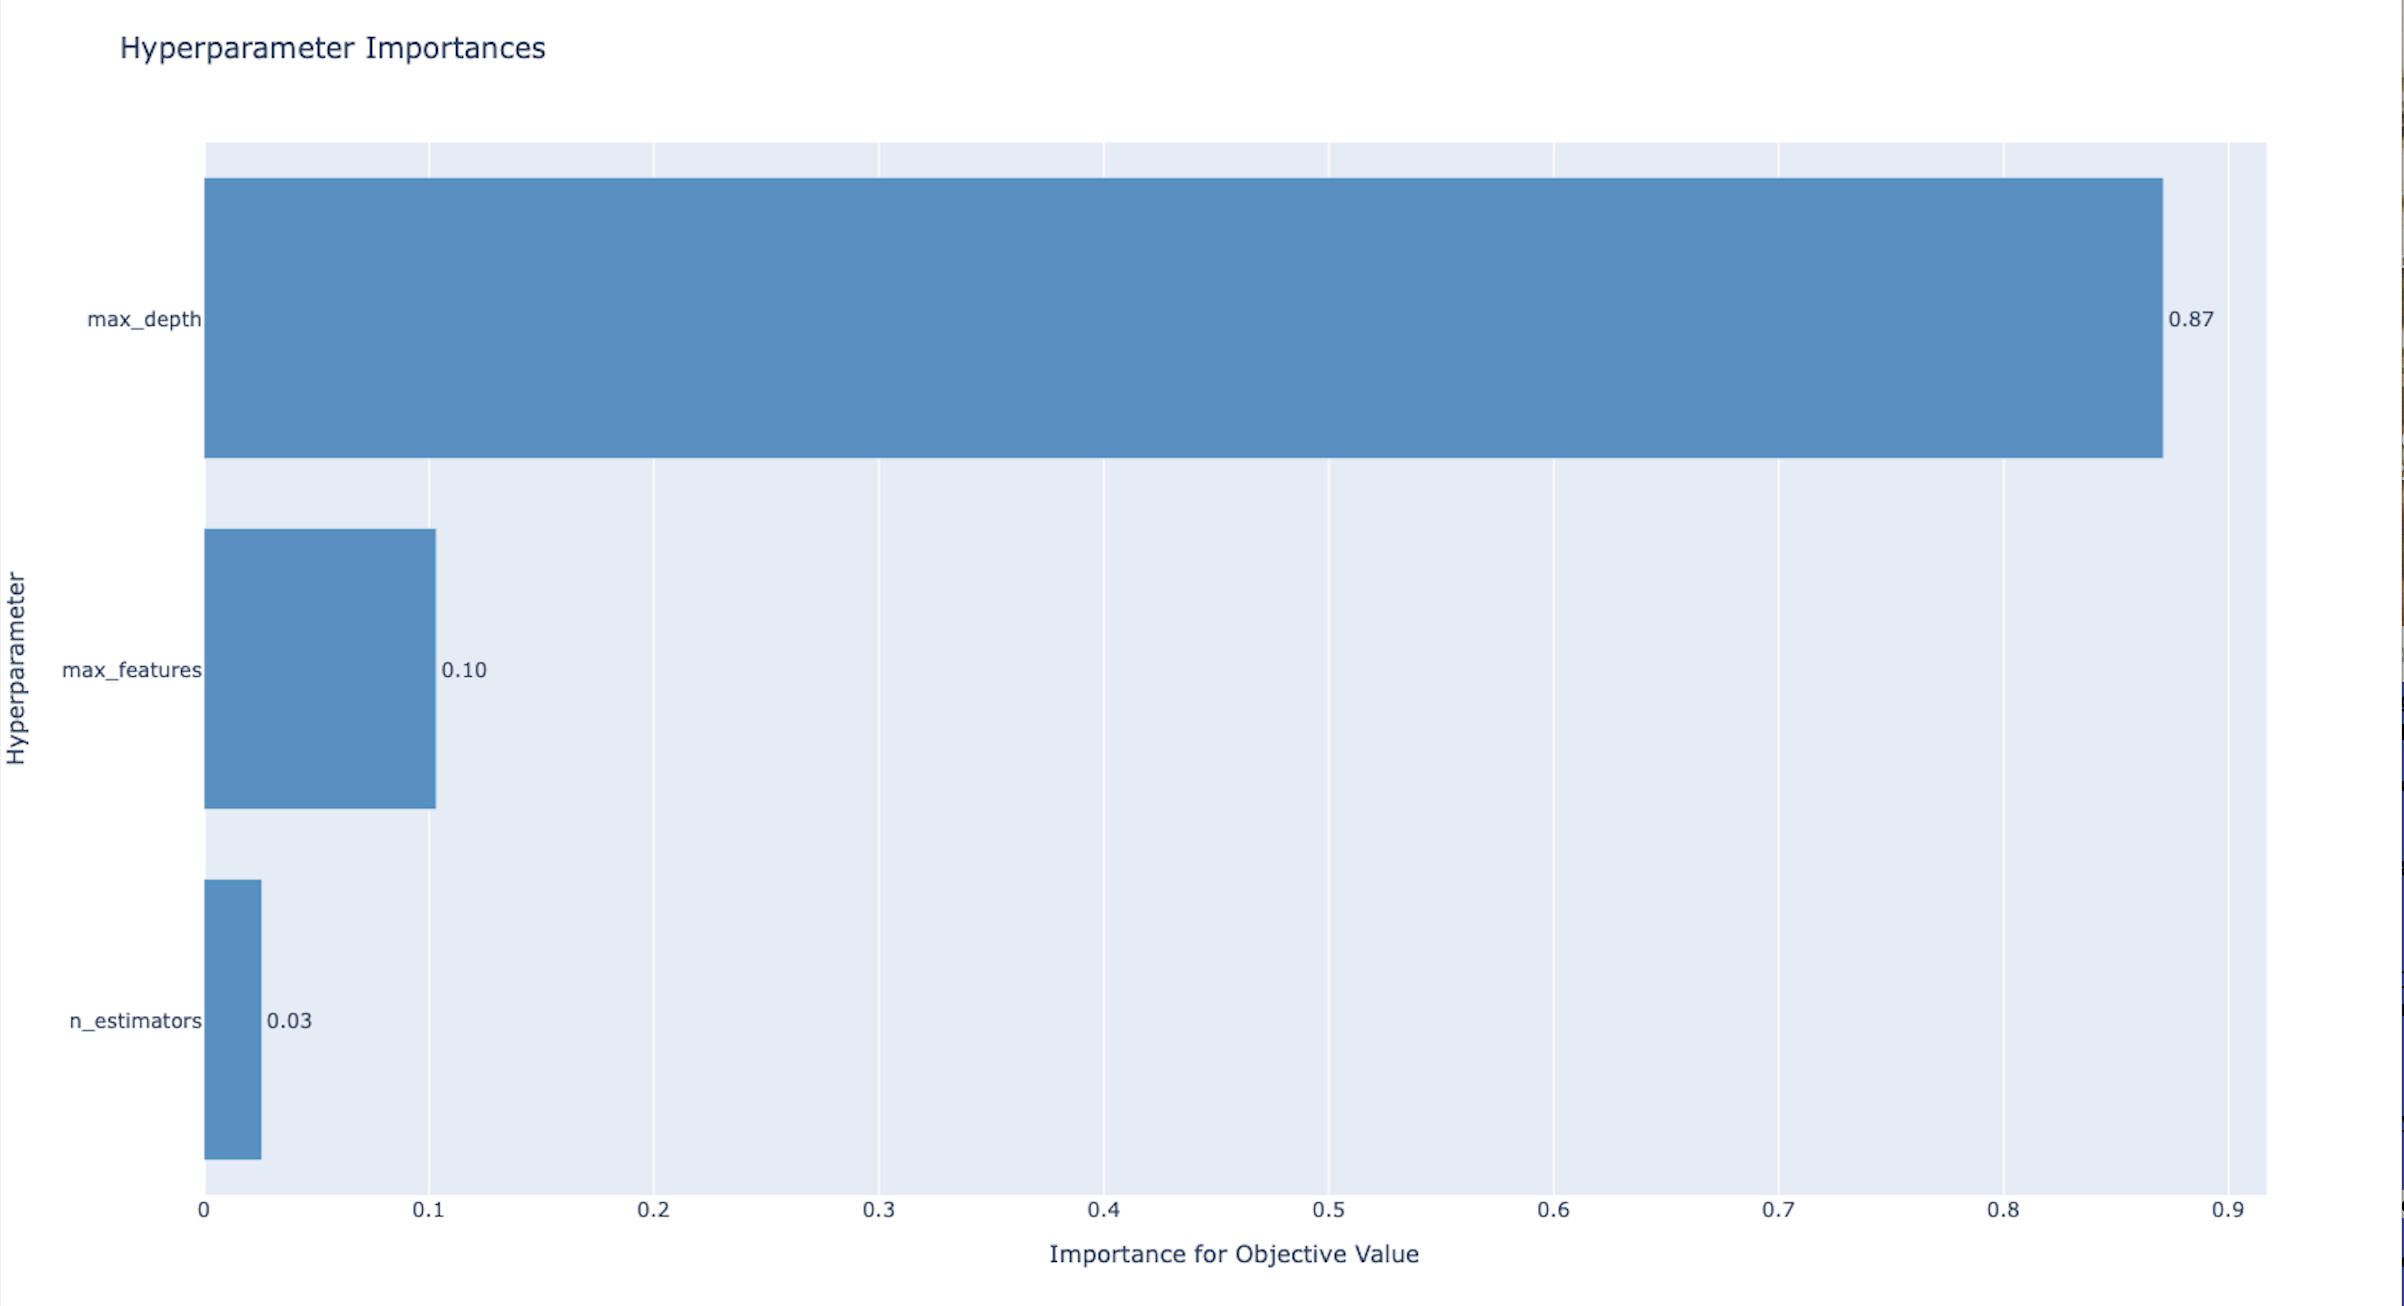

The best value optuna have found is 0.867. It is worse than the defualt 0.95. The reason is that optuna needs more time to find optimal parameters. However, for now let's stick to the default random forests algorithm.

## Business conclusion (meaning):
Here we tried many different models and compared preliminary results on the training and testing data. These preliminary results
show us that Random Forest can be considered as the best performed model (both and training and testing datasets). We may assume that it happens due to the fact that Random Forest usually handles well data with a large number of attributes and classes + it is insensitivite to scaling (and in general to any monotonic transformations) of feature values. Since LDA and QDA showed poor performance our assumption of the existence non-linear (non-quadratic) relationship may be indeed true. Overall, even though that the data collected by the company may not fully describe the features that affect much the probability of default, Random Forest and XGboost managed to perform well in such situation. But we suggest that the company may try to collect other information about the customers that will be more linearly/quadratic connected to the probability of default since other models will show better results in this case. Finally, we have tried the optuna hyperparemeters optimization framework, however did not succed.

# 4. Run the models on the test data and choose the one that showed the best performance based on the metric scores

In [ ]:
#Split the data into train/validation/test sets
targets = data_modified_rest.flag.values
features = [x for x in data_modified_rest.columns if x not in ['app_id', 'flag']]

# X_train, X_test, y_train, y_test = train_test_split(
#     data_modified,
#     targets,
#     test_size=0.15,
#     stratify=targets,
#     random_state=41
# )

# X_train, X_val, y_train, y_val = train_test_split(
#     X_train,
#     y_train,
#     test_size=0.177,
#     stratify=y_train,
#     random_state=41
# )

**Logistic regression**

In [ ]:
import pandas as pd

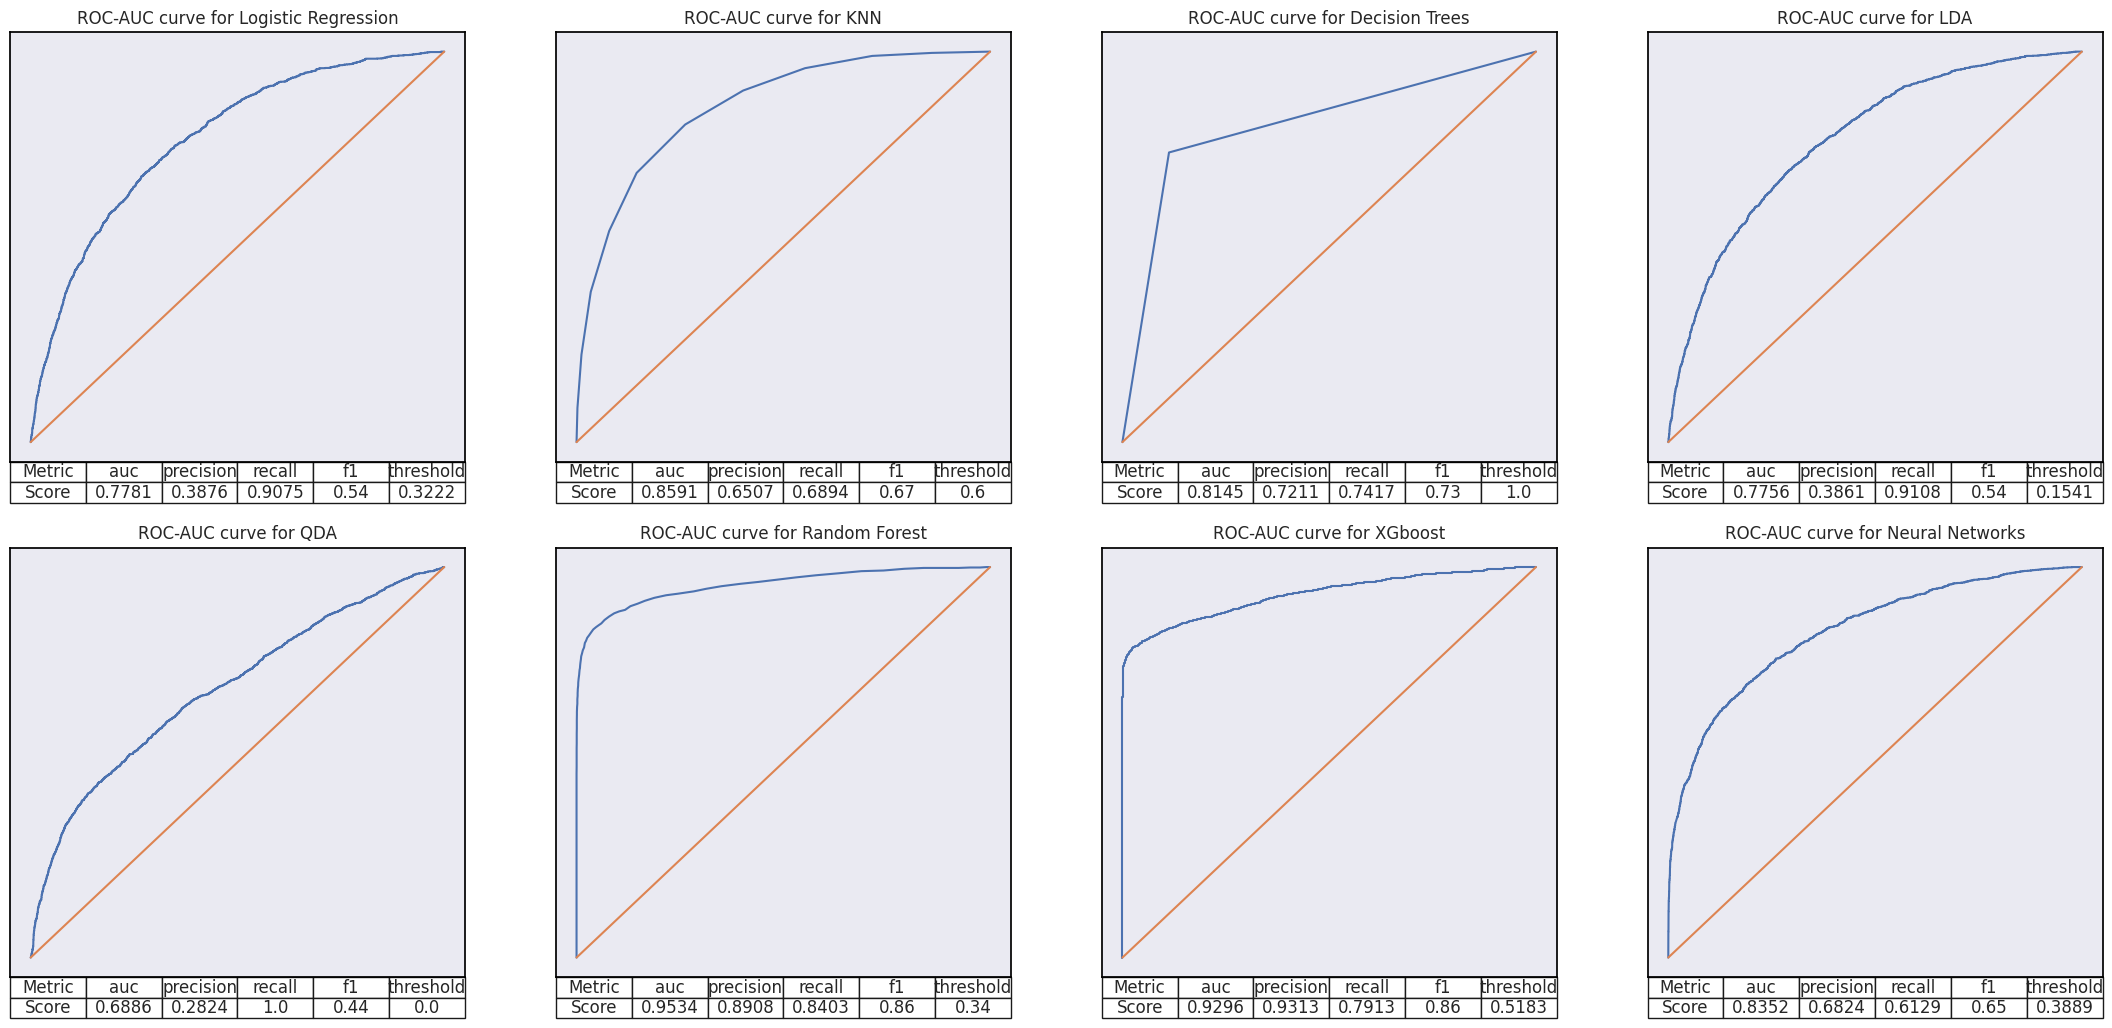

In [ ]:
data = {'Metric': ['Score'],
        'auc': [25],
        'precision': [25],
        'recall': [25],
        'f1': [25]}
df123 = pd.DataFrame(data)
models = [logreg_clf, knn_clf, dt_clf, lda_clf, qda_clf, rf_clf, xgb_clf, nn_clf]
model_names = ['Logistic Regression','KNN','Decision Trees', 'LDA', 'QDA', 'Random Forest', 'XGboost', 'Neural Networks']
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(27, 15))
for i, ax in enumerate(axs.flat):
    model = models[i]
    # y_predict = model.predict_proba(X_test[features])[:, 1]
    fpr, tpr, auc_score, precision_s, recall_s, f1, best_thresh = compute_scores(model, data_modified_rest)
    data = {'Metric': ['Score'],
        'auc': [np.round(auc_score, decimals=4)],
        'precision': [np.round(precision_s, decimals=4)],
        'recall': [np.round(recall_s, decimals=4)],
        'f1': [np.round(f1, 2)],
        'threshold': [str(np.round(best_thresh, decimals=4))]}
    df123 = pd.DataFrame(data)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1])
    ax.set_title(f"ROC-AUC curve for {model_names[i]}")
    table = ax.table(cellText=df123.values, colLabels=df123.columns, cellLoc='center', loc='bottom')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)
    for spine in ax.spines.values():
        spine.set_edgecolor('black')

    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    ax.set_xticks([])
    ax.set_yticks([])
fig.subplots_adjust(bottom=0.25)
plt.show()

## Conclusion:
Clearly, after testing we get pretty similar results - the best performed models are still the same: Random Forest and XGboost. But we see that several models slightly improved the performance (like Decision Trees and KNN). However, we will still stick to the two best performed model as their results do not signicantly differ. LDA and QDA did not show much improvement, so the assumptions about non-linear/non-quadratic relationship still persists.

# 5. Interpretation of the results (graphs, scores, feature importances)


## Feature importance (Random Forests)

As showed above, random forests algorithm performs the best on our data. Now, let's look into the algorithm and consider feature importances. Feature importances is definded as the combined decrease in impurity from splitting on this feature. For the sake of efficieny, let's plot 30 most important ones.

In [ ]:
x, y = (list(x) for x in zip(*sorted(zip(rf_clf[1].feature_importances_, features),
                                                            reverse = False)))
trace2 = go.Bar(x=x[-30:], y=y[-30:],
                marker=dict(
                    color=x,
                    colorscale = 'Burg',
                    reversescale = False), name='Random Forest Feature importance',
                orientation='h',
)

layout = dict(
    title='Barplot of Feature importances',width = 1100, height = 900,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
    ))

fig = go.Figure(data=[trace2])
fig['layout'].update(layout)
fig.show()

Interpretation: The most important feature of the Random Forest algorithm is `hour_diff__longest_strike_below_mean`. We can conclude that the longest strike below the mean of hours left from another transaction contribute the most to the perfomance of algorithm. However, we can not precisely assess the relationship between the target and the `hour_diff__longest_strike_below_mean`, because we do not know the exact structure of the target dependence. Next important features are: `amnt__count_below__t_0.1`, `amnt__minimum`, `operation_type_group_mean` with approximately equal impurity decrease. 2 out of 3 are transformation of the `amnt` variable, thus we can coclude that `amnt` variable preserves the strong dependence with target (which sounds very logical).

## SHAP (Random Forests)

In some cases common feature importance measures, as one in the previous section, could be inappropriate due to the inconsistency of the results. SHAP(SHapley Additive exPlanations) is the novel framework that provides unbaised and consistent interpretability. SHAP provides two ways of explaining a machine learning model — global and local. Let's start with global one and the summary plot.

In [ ]:
sampled_data = data_modified.sample(frac=0.1)
features = [x for x in sampled_data.columns if x not in ['app_id', 'flag']]
targets = sampled_data.flag.values
rf_clf1 = make_pipeline(StandardScaler(), xgb.XGBRFClassifier(scale_pos_weight=weights))
rf_clf1.fit(sampled_data[features], targets)
x, y = (list(x) for x in zip(*sorted(zip(rf_clf1[1].feature_importances_, features),
                                                            reverse = False)))
features = y[-30:]

In [ ]:
rf_clf1.fit(sampled_data[features], targets)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbrfclassifier',
                 XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                                 colsample_bylevel=None, colsample_bytree=None,
                                 early_stopping_rounds=None,
                                 enable_categorical=False, eval_metric=None,
                                 feature_types=None, gamma=None, gpu_id=None,
                                 grow_policy=None, importance_type=None,
                                 interaction_constraints=None, max_bin=None,
                                 max_cat_threshold=None, max_cat_to_onehot=None,
                                 max_delta_step=None, max_depth=None,
                                 max_leaves=None, min_child_weight=None,
                                 missing=nan, monotone_constraints=None,
                                 n_estimators=100, n_jobs=None,
                                 num_parallel_tree=None,
                                 objective='binary:logistic', predictor=None,
                                 random_state=None, reg_alpha=None, ...))])

In [ ]:
explainer = shap.TreeExplainer(rf_clf1[1])
shap_values = explainer.shap_values(sampled_data[features])

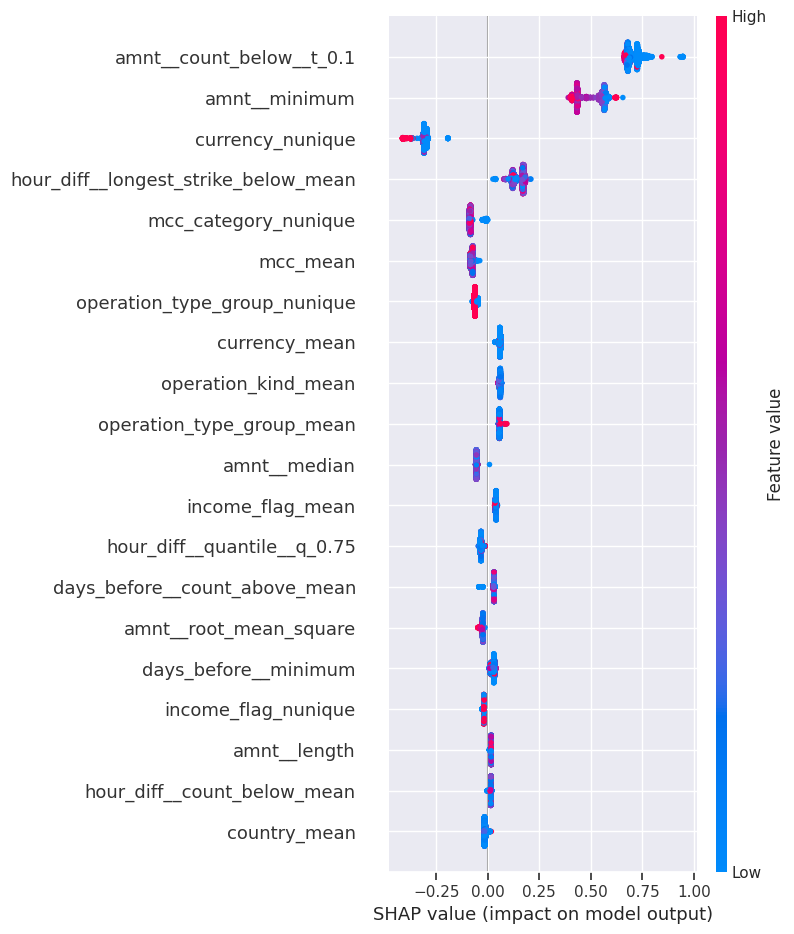

In [ ]:
shap.summary_plot(shap_values, sampled_data[features])

**Coclusion**: `amnt` is the most important variable, as its transformations lead in the list of feature importances by SHAP value. `hour_diff` and `days_before` are also importnat variables, however their aggregated SHAP is lower. Rest variables have SHAP values close to zero, depicting a little impact on the target.

Next, let's assess how features affect locally on single predictions. For this, let's firstly consider Force Plot. It shows features that contribute to pushing the output from the base value (average model output) to the actual predicted value. Red color indicates features that are pushing the prediction higher, and blue color indicates just the opposite.



In [ ]:
# Force plot of the first prediction
shap.initjs()
print('Real target value: ', targets[0])
shap.force_plot(explainer.expected_value, shap_values[0, :], sampled_data[features].reset_index(drop=True).loc[0, :], link='logit')

Real target value:  0


**Conclusion:** the predicted probability was mostly influenced by the transformations of the amount and hour_diff variables, as they push the probability towards real value 1. Clearly, only 3 or 4 features affect the prediction significantly, an affect of other variables is relatively small.

Finally, decision plot. SHAP decision plots show how complex models arrive at their predictions (i.e., how models make decisions). A decision plot can reveal how predictions change across a set of feature values. This method is useful for presenting hypothetical scenarios and exposing model behaviors.

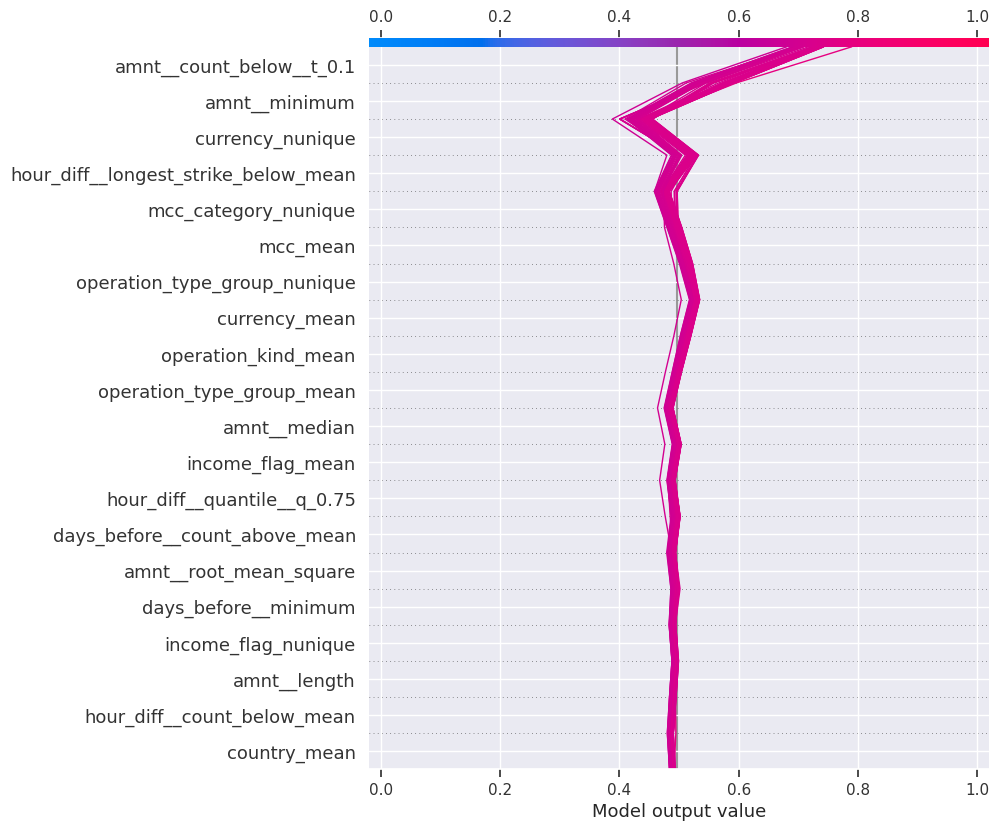

In [ ]:
shap.decision_plot(explainer.expected_value,
                shap_values[:100,:], sampled_data[features].reset_index(drop=True).loc[:100, :], link='logit')

**Conclusion:** The same picture as before. The major contribution to the final probability is made at the final stages of a decision process which contain transformation of the variables `hour_diff`, `amnt`, `eccomerse_flag`, `mcc_category`, `operation_type`. However, the final decision is mostly definded by the final 2 steps: value of the `amnt__count_below__t_0.1` and `amnt__minimum` variables.

# Partial dependence (Random Forest)

In [ ]:
features = [x for x in sampled_data.columns if x not in ['app_id', 'flag']]

In [ ]:
print(features.index("hour_diff__longest_strike_below_mean"),
      features.index("amnt__minimum"),
      features.index("days_before__minimum"),
      features.index("ecommerce_flag_nunique"),
      features.index("amnt__count_below__t_0.1"),
      features.index("amnt__longest_strike_below_mean"))

46 19 39 70 4 6


In [ ]:
srt = sorted(zip(rf_clf[1].feature_importances_, features),reverse = False)
pd_feat = []
for i in srt[::-1]:
  pd_feat.append(i[1])

In [ ]:
pd_feat_index = [features.index(i) for i in pd_feat]

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

In [ ]:
# sns.set()
# ss = StandardScaler()
# X_ = train[features][:1000].copy()
# X_[X_.columns]= ss.fit_transform(X_[X_.columns])
# PartialDependenceDisplay.from_estimator(rf_clf[1], X_, pd_feat_index[:15])
# plt.show()

many graphs show horizontal lines in the biggest of the domain, that means that on average they alone do not contribute the default probility variantion. Let's consider some them, the most interesting ones, below


In [ ]:
print("hour_diff__longest_strike_below_mean's mean:", train[features]["hour_diff__longest_strike_below_mean"].mean())
print("amnt__mean's mean:", train[features]["amnt__mean"].mean())
print("amnt__longest_strike_below_mean's mean:", train[features]["amnt__longest_strike_below_mean"].mean())

hour_diff__longest_strike_below_mean's mean: 10.73497579849477
amnt__mean's mean: 0.3778240039246808
amnt__longest_strike_below_mean's mean: 6.746740159627584


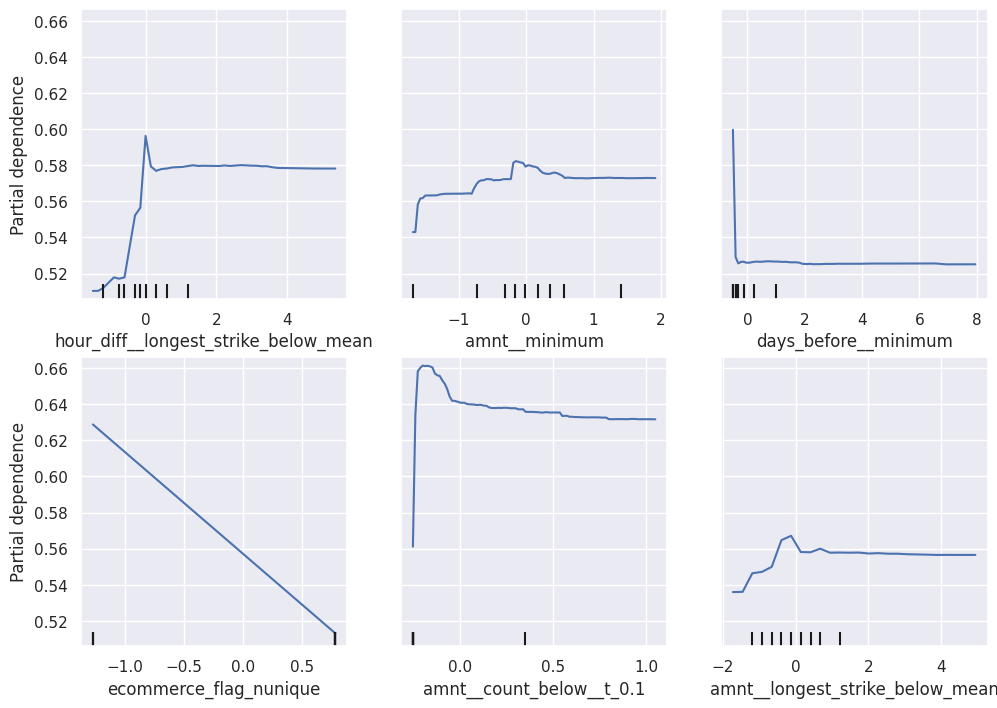

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ss = StandardScaler()
X_ = train[features][:1000].copy()
X_[X_.columns]= ss.fit_transform(X_[X_.columns])
PartialDependenceDisplay.from_estimator(rf_clf[1], X_, [46, 19, 39, 70, 4, 6])
plt.show()

The above graph show partial dependence of the most important features. On the upper left plot (partial dependence vs hour_diff__longest_strike_below_mean) we observe that if the greatest length of consecutive sequence of hours passed from the last client's transaction below the mean is greater than the mean (do not forget that that the data were standardazed before training), then the feature seem to have very little effect on the target variable. On the other hand, the greatest length of consecutive sequence of hours passed from the last client's transaction below the mean in the region (-1, 0) show uppward motion. Intepretation of the variable in business sense would be: the longest period of time when the client makes transactions with higher rate when their mean tempo has positive effect to the default probability if the this value is below its mean (10.74), otherwise there is no effect on default probabilty. It is also, interesting that the highest default probability is among those people whose longest period of time when they makes transactions with higher rate when their mean tempo is just a little below the mean value (10.74).

amnt minimum vs partial dependence shows that on average people with the minimum (among other clients) minimum amount (among client's transactions) are the least likely have the default. Generalizing the partial this graph we can conclude that it shows that the probability of default is decreasing as client's minimum normalzed transaction amount decreases

On partial dependence vs days_before__minimum we see that on average people with the lowest value of days before they get a loan are more likely to have default.

From partial dependence vs ecommerce_flag_nunique we can retrieve that on average those who have transaction with and without eccomerce flag are less likely to have a default.

From partial dependence vs amnt__count_below__t_0.1 we observe that on aberage those with the minimal number of transaction with normalized amount below 0.1 are the least likely to face a default amnt__count_below__t_0.1 grows the probability ,firstly, rapidly increases, then gradually decreases.

Partial dependence vs amnt__longest_strike_below_mean show the similar situation as partial dependence vs hour_diff__longest_strike_below_mean. The longest period of time when a client makes transactions with amount less than the mean amount has positive effect to the default probability if the this value(amnt__longest_strike_below_mean) is below its mean (6.75)

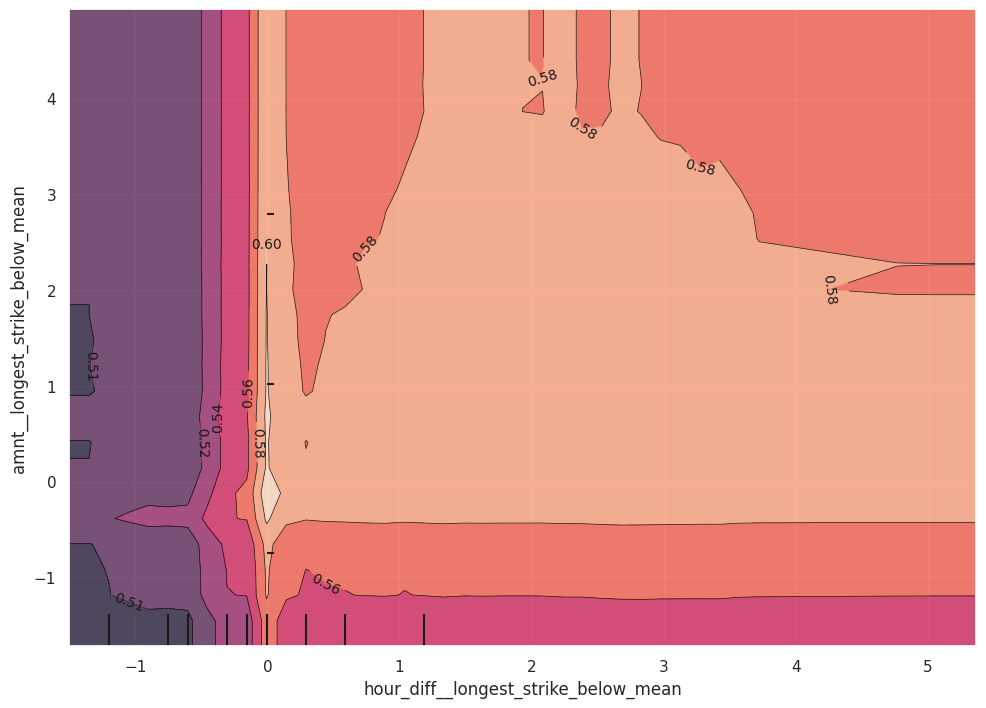

In [ ]:
ss = StandardScaler()
X_ = train[features][:1000].copy()
X_[X_.columns]= ss.fit_transform(X_[X_.columns])
PartialDependenceDisplay.from_estimator(rf_clf[1], X_, [(46, 6)])
plt.show()

On this graph we can see the the joint influence of hour_diff__longest_strike_below_mean and amnt__longest_strike_below_mean. People with highest probability of are those with the longest period of time when the client makes transactions with higher rate when their mean tempo and the longest period of time when a client makes transactions with amount less than the mean amount are just a little above (about 0.02) and little below (about 0.07) the mean value. We can also observe that the clients with he longest period of time when the client makes transactions with higher rate when their mean tempo and the longest period of time when a client makes transactions with amount less than the mean amount above the accroding mean (greater then 0 on the graph, do not forget that data is normilized) has approximately 0.52 probability of default, interestingly that the probability does not really change in that region with change in either of variables.

# XGBoost interpretation

In [ ]:
x, y = (list(x) for x in zip(*sorted(zip(xgb_clf[1].feature_importances_, features),
                                                            reverse = False)))
trace2 = go.Bar(x=x[-30:], y=y[-30:],
                marker=dict(
                    color=x,
                    colorscale = 'Burg',
                    reversescale = False), name='Random Forest Feature importance',
                orientation='h',
)

layout = dict(
    title='Barplot of Feature importances',width = 1100, height = 900,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
    ))

fig = go.Figure(data=[trace2])
fig['layout'].update(layout)
fig.show()

XGboost yeilds slightly diffrent features to be the most important. Now the most important one is the number of unique countries in transactions. Ecommerce_flag_nunique that means that means whether client has ecommerce and non-ecommerce transactions. Operation_type_group_nunique means number of unique cards groups in a client's transactions. Let's consider this features in details below

In [ ]:
srt = sorted(zip(xgb_clf[1].feature_importances_, features),reverse = False)
pd_feat = []
for i in srt[::-1]:
  pd_feat.append(i[1])

In [ ]:
pd_feat_index = [features.index(i) for i in pd_feat]

In [ ]:
mu_cu = train[features]['country_nunique'].mean()

In [ ]:
sigma_cu = train[features]['country_nunique'].std()

In [ ]:
-0.5*sigma_cu + mu_cu

1.0288165192533039

In [ ]:
1.25*sigma_cu + mu_cu

3.0226405796662403

In [ ]:
mu_ot = train[features]['operation_type_group_nunique'].mean()
sigma_ot = train[features]['operation_type_group_nunique'].std()

In [ ]:
-1.5*sigma_ot+mu_ot

1.0671401695919633

In [ ]:
0.5*sigma_ot+mu_ot

2.011614020696366

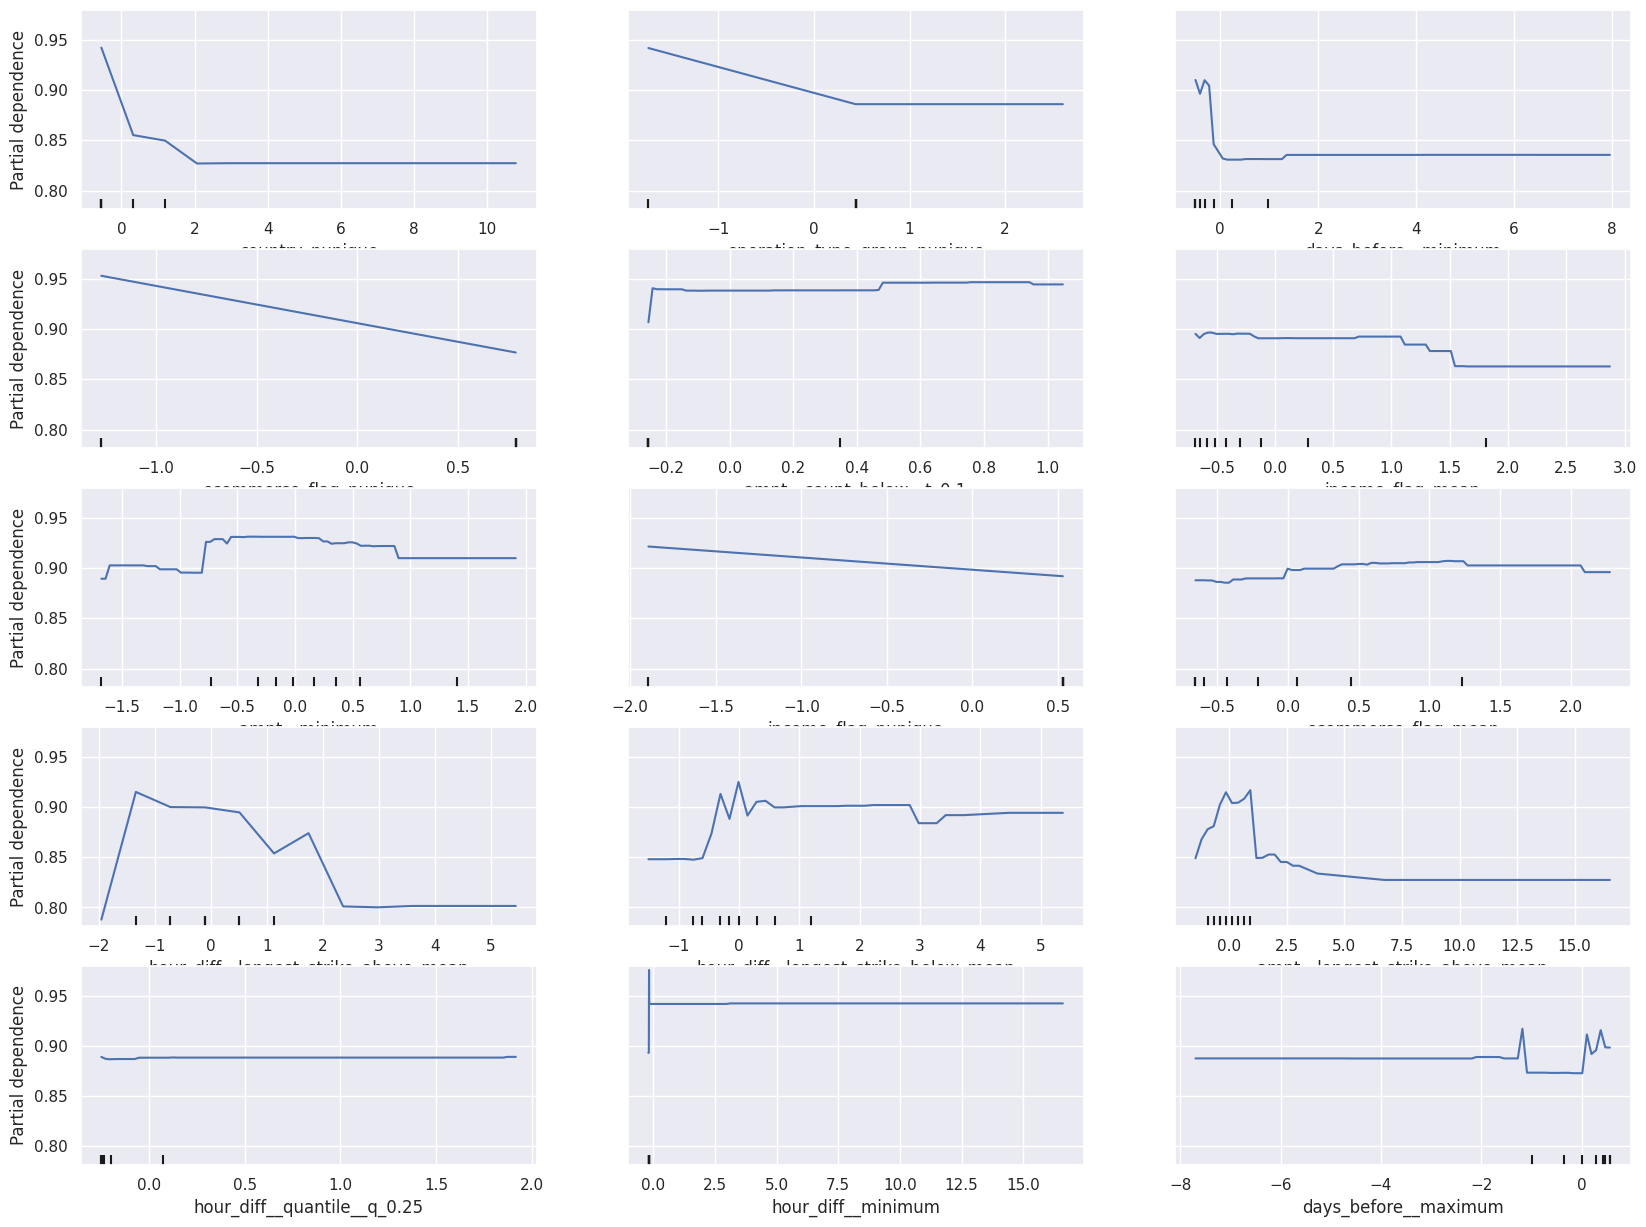

In [ ]:
sns.set(rc={'figure.figsize':(20,15)})
PartialDependenceDisplay.from_estimator(xgb_clf[1], X_, pd_feat_index[:15])
plt.show()

On partial effect vs country_nunique: the partial effect of number of unique countries feature. Keeping in mind that the training data has been normilized and observing that in (-0.5, 1,25) interval the graph is decreasing while in the rest of the domain it is more less constant we may say that the number of unique countries has a positive effect untill it gets to big. As country_nunique changes from 1 to 3 the probability of default is decreasing. From 3 and on the probability seems to be constant

From partial dependence vs ecommerce_flag_nunique we can retrieve that on average those who have transaction with and without eccomerce flag are less likely to have a default. Aproximately, 5% less


Inversing standard scaler we observe that as number of unique card groups increases from 1 to 2 it decreases the probability of default. I assume that the 2 unique group from the most of the clients would be credit card (1st is debit). So, losely speaking one may say that peolpe using credit and debit card are almost 10% less likley to have a default

In [ ]:
sampled_data = data_modified.sample(frac=0.2)
features = [x for x in sampled_data.columns if x not in ['app_id', 'flag']]
targets = sampled_data.flag.values
xgb_clf = make_pipeline(StandardScaler(), xgb.XGBClassifier(scale_pos_weight=weights, booster="gbtree"))
xgb_clf.fit(sampled_data[features], targets)
x, y = (list(x) for x in zip(*sorted(zip(xgb_clf[1].feature_importances_, features),
                                                            reverse = False)))
features = y[-30:]

In [ ]:
xgb_clf.fit(sampled_data[features], targets)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster='gbtree',
                               callbacks=None, colsample_bylevel=None,
                               colsample_bynode=None, colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [ ]:
explainer = shap.TreeExplainer(xgb_clf[1])
shap_values = explainer.shap_values(sampled_data[features])

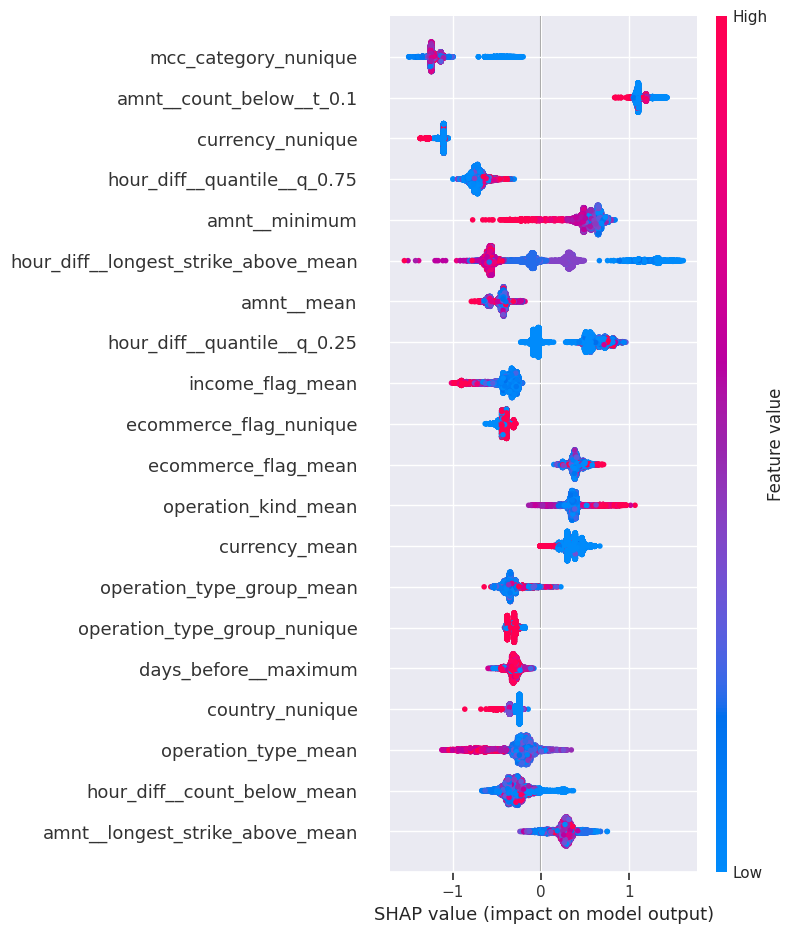

In [ ]:
shap.summary_plot(shap_values, sampled_data[features])

Here we can also, look at shap's summary plot. The summary plot integrates the significance of features with their respective impacts. Every data point on the summary plot corresponds to a Shapley value for a specific feature and instance. The vertical position of each point indicates the feature, while the horizontal position represents the Shapley value. The color of the point signifies the feature's value, ranging from low to high. In order to visualize the distribution of Shapley values for each feature, overlapping points are slightly scattered along the y-axis. The features are arranged based on their level of importance.

Mostly we see the same situation as with Random Forest: amnt is the most important variable as well as ecommerce_flag and hour_diff. But now also we observe the currency_nunique and currency_mean are among the most important ones. For these two variables, observing that blue points are on the right side while the red ones are on the left we may conclude that the number of different currencies has negetive effect on default probability.

# 6. Text description “how to implement the best model in the prod now and how the model needs to be maintained”

### a) To implement the best model in production and maintain its effectiveness, it is necessary to perform the following steps:

- Data preparation:<br>
Make sure that the data in production matches the data on which the model was trained. If the data has changed, it is necessary to model or retrain on the new data.
- Deploying the model:<br>
Creating an infrastructure for deploying the model, for example, using Docker containers or Flask servers.<br>
- Installing the necessary dependencies and libraries to run the model.
Ensuring the scalability and fault tolerance of the system to handle a large volume of requests and maintain the availability of the model.
- Monitoring model performance:<br>
Setting performance metrics that need to be monitored, for example, AUC-ROC and F1-measure.
- Determination of threshold values for metrics, at which the model can be considered ineffective and requires updating.
- Regular monitoring of metrics, comparing them with thresholds and making decisions about the need to update the model.
- Backup and Restore:<br>
Regularly it is necessary to create backups of the model and important data for the possibility of recovery in case of failures or data loss.
We need to make sure that the recovery process is checked and ready for use.

### b) Sample ways to use the created model:

1. Online scoring:<br>
- Using a model to predict default for individual customers in real time when new data arrives.
- The model can be embedded in a web application, API, or service to provide predictions based on input data.
2. Batch forecasting:<br>
- The model can be used for batch forecasting based on large amounts of data, for example, to assess the risk of default for the entire portfolio of bank customers.
3. Optimization of the lending strategy:
- The model can be used to analyze and optimize the lending strategy. Based on the predictions of the model, it is possible to determine which parameters and criteria should be taken into account when making decisions on granting a loan in order to maximize profitability and reduce risks.

### c) Create pros/cons list for each model (briefly):
1. Logistic Regression has a decent  AUC-ROC (0.7775) and F1-score (0.58):
* Advantages:
Simplicity and interpretability.
Fast prediction.
Works well with large datasets.
* Disadvantages:
Assumes a linear relationship between features and the log-odds of the target variable.
May not perform well with complex relationships in the data (that is actually the case).
Slow training due to the MLE.

2. Linear Discriminant Analysis (LDA) has similar to Logistic Regression AUC-ROC(0.7757) and F1-score (0.58):
* Advantages:
Assumes linear decision boundaries.
Robust to outliers.
* Disadvantages:
Assumes normality and equal covariance matrices for each class.
Limited to linear decision boundaries.
LDA is less flexible and unable to handle complex nonlinear dependencies between features (that is actually the case).

3. Quadratic Discriminant Analysis (QDA) showed worst results in terms of AUC-ROC (0.6991) and F1-score (0.52):
* Advantages:
Can capture non-linear(quadratic) relationships between features and the target variable.
More flexible than LDA.
* Disadvantages:
Requires more training data compared to LDA.
Proneness to overfitting, especially with high-dimensional data (that might have happened in our case).

4. k-Nearest Neighbors (KNN) was the third best-performed model with AUC-ROC = 0.8761 and F1-score = 0.7:
* Advantages:
Simple and easy to understand.
Non-parametric and can capture complex relationships.
Works well with both classification and regression problems.
* Disadvantages:
Computationally expensive during prediction.
Sensitive to the choice of distance metric and the number of neighbors.

5. Decision Tree also showed decent results, the AUC-ROC is 0.82, while the F-score is 0.74:
* Advantages:
Easy to interpret and visualize.
Can handle both numerical and categorical data.
Non-parametric and can capture non-linear relationships.
* Disadvantages:
Prone to overfitting, especially with deep trees.
May be unstable due to high variance.
6. Random Forests was our best-performed model with AUC-ROC = 0.96 and F1-score = 0.87:
* Advantages:
Combines multiple decision trees to reduce overfitting.
Handles high-dimensional data well.
Robust to outliers and noise.
* Disadvantages:
Lack of interpretability compared to individual decision trees.
Computationally expensive during training.

7. Gradient Boosting was the second best-performed model with similar to Random Forest metric scores (AUC-ROC = 0.94 and F1-score = 0.85):
* Advantages:
Highly accurate and powerful, often leading to state-of-the-art results.
Can handle a variety of data types and distributions.
Less prone to overfitting than individual decision trees.
* Disadvantages:
Computationally expensive and time-consuming to train.
Sensitive to hyperparameter tuning.

8. Neural Networks performance was relatively good with AUC-ROC = 0.835 and F1-score = 0.64, while the model was trained for a long time and it is the most computationally expensive model among others:
* Advantages:
Can model complex relationships and patterns.
Highly flexible and capable of handling various types of data.
Can learn hierarchical representations.
* Disadvantages:
Computationally intensive, requiring substantial resources.
Requires a large amount of labeled data for training.
Prone to overfitting, especially with limited data.

### d) Draw a  general conclusion:
Based on the provided metrics, the Random Forest model shows the highest efficiency in terms of AUC-ROC and F1-measures. It has a good ability to predict default. In addition, the XGboost model also shows good results, especially with respect to the F1-measure.

When choosing a model for implementation in production, it is necessary to take into account such factors as computing resources, training time, flexibility of the model, as well as data processing requirements. In addition, it is important to regularly monitor the performance of the model and consider updating the model based on changes in data or requirements.

Scoring models should work fast, as they receive thousands/millions of API requests per day. Therefore, it might be optimal to use simple solutions in production, for example, logistic regression, which also showed a fairly good result with ROC-AUC 0.78.

A powerful computing infrastructure is required to maintain and monitor models-ensembles, neural networks. What is more, such complex models (like Random Forest) can be difficult to interpret, so maybe we should not consider it as the final model for production.

The final choice of a model for implementation in production should be based on a compromise between performance, resource requirements, complexity of implementation and interpretability of the model.

# Workshop

In [ ]:
# Undersampling
model = LogisticRegression()
# dividing the dataset into classes
data_class_0 = data[data['flag'] == 0]
data_class_1 = data[data['flag'] == 1]

# Reduce a larger class by deleting existing examples
data_class_0_undersampled = resample(data_class_0,
                                    replace=False,    # sampling without repetitions
                                    n_samples=len(data_class_1), # number of samples
                                    random_state=42)  # reproducing the results

# combining both classes
data_undersampled = pd.concat([data_class_0_undersampled, data_class_1])

X = data_undersampled.drop('flag', axis=1)
y = data_undersampled['flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# evaluating the quality of the model using cross-validation
scores = cross_val_score(model, X, y, cv=5)
print(f"Mean accuracy: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")

# Training a model on all data
model.fit(X, y)

# predictions based on test data
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
# Oversampling

model = LogisticRegression()
# dividing the dataset into classes
data_class_0 = data[data['flag'] == 0]
data_class_1 = data[data['flag'] == 1]

# increasing the smaller class by copying existing examples
data_class_1_oversampled = resample(data_class_1,
                                  replace=True,     # return a selection with repetitions
                                  n_samples=len(data_class_0), # number of samples
                                  random_state=42)  # reproducing the results

# combining both classes
data_oversampled = pd.concat([data_class_0, data_class_1_oversampled])

# dividing the data into attributes and a target variable
X = data_oversampled.drop('flag', axis=1)
y = data_oversampled['flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# evaluating the quality of the model using cross-validation
scores = cross_val_score(model, X, y, cv=5)
print(f"Mean accuracy: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")

# training the model on all the data
model.fit(X, y)

# making predictions based on test data
y_pred = model.predict(X_test)

# classification report
print(classification_report(y_test, y_pred))

In [ ]:
# SMOTE
#separation of data into attributes and target variable
X = data.drop('flag', axis=1)
y = data['flag']

#Creating an instance of SMOTE
sm = SMOTE(random_state=42)

#Apply SMOTE to the data
X_res, y_res = sm.fit_resample(X, y)

#Evaluation of model quality using cross-validation
scores = cross_val_score(model, X_res, y_res, cv=5)
print(f"Mean accuracy: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")

#Training the model on all data
model.fit(X_res, y_res)

# prediction based on test data
y_pred = model.predict(X_test)

# classification report
print(classification_report(y_test, y_pred))

In [ ]:
# Random Forest Classifier (Ensembles)
X = data.drop('flag', axis=1)
y = data['flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)

scores = cross_val_score(rf, X, y, cv=5)
print(f"Mean accuracy: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

In [ ]:
# Creating an instance of the classifier (Local Outlier Factor)
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)

y_pred = clf.fit_predict(X)

# extracting only normal examples
X_inliers = X[y_pred == 1]

# extracting only anomaly examples
X_outliers = X[y_pred == -1]

rf = RandomForestClassifier(n_estimators=100, random_state=42)

# placing data on normal and abnormal examples
y = [0] * len(X_inliers) + [1] * len(X_outliers)
X = np.concatenate([X_inliers, X_outliers])

cv_scores = cross_val_score(rf, X, y, cv=5)

print('Cross-validation score:', np.mean(cv_scores))
print(classification_report(y, rf.fit(X, y).predict(X)))

In [ ]:
X_prev = data.drop('flag', axis=1)
y_prev = data['flag']

sm = SMOTE(sampling_strategy = 0.1, random_state=42)

X_new, y_new = sm.fit_resample(X_prev, y_prev)

In [ ]:
numeric_features = ['days_before', 'hour_diff']

float_features = ['amnt']

categorical_features = [
    'currency', 'operation_kind', 'card_type',
    'operation_type', 'operation_type_group', 'ecommerce_flag',
    'payment_system', 'income_flag', 'mcc', 'country', 'city',
    'mcc_category', 'day_of_week', 'hour', 'weekofyear'
]

In [ ]:
def __amnt_pivot_table_by_column(data, column, agg_funcs=None):
    """
    Строит pivot table для между колонкой `amnt`  и column на основе
    переданных aggregations
    """

    if agg_funcs is None:
        agg_funcs = ['mean', 'count', 'median', 'std']

    aggregates = pd.pivot_table(
        data,
        values='amnt',
        index=['app_id'],
        columns=[column],
        aggfunc={'amnt': agg_funcs},
        fill_value=0.0
    )

    aggregates.columns = [
        f'{col[0]}_{column}_{col[1]}' for col in aggregates.columns.values
    ]

    return aggregates


def extract_basic_aggregations(transactions_frame, cat_columns=None, agg_funcs=None):

    if not cat_columns:
        cat_columns = categorical_features

    pivot_tables = []

    for col in cat_columns:
        pivot_tables.append(__amnt_pivot_table_by_column(
            transactions_frame,
            column=col,
            agg_funcs=agg_funcs
        ))

    pivot_tables = pd.concat(pivot_tables, axis=1)

    aggs = {
        'amnt': ['min', 'max', 'mean', 'median', 'sum', 'std'],
        'hour_diff': ['max', 'mean', 'median', 'var', 'std'],
        'days_before': ['min', 'max', 'median']}

    numeric_stats = transactions_frame.groupby(['app_id']).agg(aggs)

    numeric_stats.columns = [
        k + '_' + agg for k in aggs.keys() for agg in aggs[k]
    ]

    return pd.concat([pivot_tables, numeric_stats], axis=1).reset_index()


def prepare_transactions_dataset(
    dataset,
    verbose=False):
    """
    возвращает готовый pd.DataFrame с признаками, на которых можно учить
    модель для целевой задачи
    """
    preprocessed_frames = []

    transactions_frame = TRAIN_TRANSACTIONS

    features = extract_basic_aggregations(
            transactions_frame,
            cat_columns=[
                'mcc_category',
                'day_of_week',
                'operation_type',
                'operation_type_group',
                'country',
                'currency',
                'operation_kind',
                'ecommerce_flag'
            ])
    preprocessed_frames.append(features)
    return pd.concat(preprocessed_frames)

In [ ]:
def pie_chart_by_feature(data, feature):

    plt.figure(figsize=(10, 6))

    data[feature].value_counts().plot(
        kind='pie', label=f'{feature}',
        autopct='%.2f%%', pctdistance=1.3,
        labeldistance=1.1
    )
    plt.legend()
    plt.axis('equal')
    plt.show()

In [ ]:
def plot_roc_curve(title, fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""

    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(12, 8))

    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr,
                tpr,
                lw=1,
                alpha=0.3,
                label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc)
        )

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Constant Random Model', alpha=.8)

    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    ax.plot(
        mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8
    )

    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

    ax.fill_between(
        mean_fpr, tprs_lower, tprs_upper,
        color='grey', alpha=.2,
        label=r'$\pm$ 1 std. dev.'
    )

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for {title} model')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)


def compute_roc_auc(clf, section):
    y_predict = clf.predict_proba(section[features])[:, 1]
    fpr, tpr, thresholds = roc_curve(section.flag.values, y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

In [ ]:
num_0 = len(train_dataset[train_dataset['flag']==0])
num_1 = len(train_dataset[train_dataset['flag']==1])
print(num_0,num_1)
# случайный андерсэмплинг
undersampled_data = pd.concat([ train_dataset[train_dataset['flag']==0].sample(num_1) , train_dataset[train_dataset['flag']==1] ])

In [ ]:
pie_chart_by_feature(undersampled_data, 'flag')

In [ ]:
targets = undersampled_data.flag.values
features = [x for x in undersampled_data.columns if x not in ['app_id', 'flag']]

cv = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)
fprs, tprs, scores = [], [], []

logreg_clf = make_pipeline(StandardScaler(), LogisticRegression(
    random_state=41,
    class_weight='balanced',
    C=0.1,
    penalty='l2'
))

for fold_, (train_idx, val_idx) in enumerate(cv.split(undersampled_data, targets), 1):
    print(f'Training with fold {fold_} started.')

    train, val = undersampled_data.iloc[train_idx], undersampled_data.iloc[val_idx]

    logreg_clf.fit(train[features], train.flag.values)
    _, _, auc_score_train = compute_roc_auc(logreg_clf, train)
    fpr, tpr, auc_score = compute_roc_auc(logreg_clf, val)
    print('Val ROC-AUC:', auc_score)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)
    print(f'Training with fold {fold_} completed.')

plot_roc_curve('Logistic Regression', fprs, tprs)
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])